# Rapport Projet Analyse des Réseaux Sociaux
# P0 Détection d’intrusions cyber


Réalisé par :
----------
* Groupe 08
  * KAFANDO Tounwendsida Bertrand
  * BASLAM Ismail


Plan 
----------
1. Récuperation et Etude de la dataset
2. Construire un réseau
3. Classification Binaires des données
4. Generation des mesures et classification
5. Evaluation de l'importance des variables ajoutées


#

L’objectif de ce projet est de mobiliser les
techniques d’analyse des réseaux afin d’enrichir l’ensemble d’attributs d’un
paquet par des mesures calculés à partir de la topologie du réseau d’interaction afin d’améliorer les performances des la classification automatique des
paquets

## 1- Récuperation et Etude du Dataset

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [3]:
import pandas as pd

def query_for_structure(database, table_name):
    # Hypothetical function to retrieve table structure
    return [{'Name': 'column1'}, {'Name': 'column2'}, {'Name': 'column3'}]

def execute_query(query):
    # Hypothetical function to execute a SQL query using AWS Athena
    # This function should return data in a format compatible with pandas DataFrame creation
    return {
        'QueryID': 'example_query_id',
        'QueryExecutionState': 'SUCCEEDED',
        'Response': {
            'Rows': [
                {'Data': [{'VarCharValue': 'column1'}, {'VarCharValue': 'column2'}, {'VarCharValue': 'column3'}, {'VarCharValue': 'Comparison_Result'}]},
                {'Data': [{'VarCharValue': '1'}, {'VarCharValue': 'Data1'}, {'VarCharValue': 'DataA'}, {'VarCharValue': 'Value match'}]},
                {'Data': [{'VarCharValue': '2'}, {'VarCharValue': 'Data2'}, {'VarCharValue': 'DataB'}, {'VarCharValue': 'Value mismatch'}]},
                {'Data': [{'VarCharValue': '3'}, {'VarCharValue': 'Data3'}, {'VarCharValue': 'DataC'}, {'VarCharValue': 'Value match'}]}
            ]
        }
    }

def tower_joining(data_base_old, data_base_new, table_name, tech_id):
    structure_new = query_for_structure(data_base_old, table_name)
    list_col = [item['Name'] for item in structure_new]

    join_conditions = " AND ".join(f"a.{id} = b.{id}" for id in tech_id)
    equality_conditions = " AND ".join(f"a.{col} = b.{col}" for col in list_col)

    case_statement = f"""
    CASE
        WHEN NOT ({equality_conditions}) THEN 'Value mismatch'
        ELSE 'Value match'
    END AS Comparison_Result
    """

    query = f"""
    SELECT a.*, {case_statement}
    FROM {data_base_old}.{table_name} a
    FULL OUTER JOIN {data_base_new}.{table_name} b
    ON {join_conditions}
    """

    result = execute_query(query)
    return result

# Parameters
data_base_old = 'old_database'
data_base_new = 'new_database'
table_name = 'your_table'
tech_id = ['id']  # The technical ID or primary key used for joins

# Execute the function and convert results to DataFrame
result_dict = tower_joining(data_base_old, data_base_new, table_name, tech_id)
column_names = [data['VarCharValue'] for data in result_dict['Response']['Rows'][0]['Data']]
data_rows = [[data['VarCharValue'] for data in row['Data']] for row in result_dict['Response']['Rows'][1:]]
df = pd.DataFrame(data_rows, columns=column_names)

# Filter DataFrame to show only rows with 'Value match'
df_no_issues = df[df['Comparison_Result'] == 'Value match']

# Output the DataFrame with no issues
print(df_no_issues)


  column1 column2 column3 Comparison_Result
0       1   Data1   DataA       Value match
2       3   Data3   DataC       Value match


In [4]:
import pandas as pd

def query_for_structure(database, table_name):
    # Hypothetical function to retrieve table structure
    return [{'Name': 'column1'}, {'Name': 'column2'}, {'Name': 'column3'}]

def execute_query(query):
    # Hypothetical function to execute a SQL query using AWS Athena
    # This function should return data in a format compatible with pandas DataFrame creation
    return {
        'QueryID': 'example_query_id',
        'QueryExecutionState': 'SUCCEEDED',
        'Response': {
            'Rows': [
                {'Data': [{'VarCharValue': 'column1'}, {'VarCharValue': 'column2'}, {'VarCharValue': 'column3'}, {'VarCharValue': 'Comparison_Result'}]},
                {'Data': [{'VarCharValue': '1'}, {'VarCharValue': 'Data1'}, {'VarCharValue': 'DataA'}, {'VarCharValue': 'Value match'}]},
                {'Data': [{'VarCharValue': '2'}, {'VarCharValue': 'Data2'}, {'VarCharValue': 'DataB'}, {'VarCharValue': 'Value mismatch'}]},
                {'Data': [{'VarCharValue': '3'}, {'VarCharValue': 'Data3'}, {'VarCharValue': 'DataC'}, {'VarCharValue': 'Value match'}]}
            ]
        }
    }

def tower_joining(data_base_old, data_base_new, table_name, tech_id):
    structure_new = query_for_structure(data_base_old, table_name)
    list_col = [item['Name'] for item in structure_new]

    # Join conditions based on tech_id
    join_conditions = " AND ".join(f"a.{id} = b.{id}" for id in tech_id)
    # Equality conditions for all columns
    equality_conditions = " AND ".join(f"a.{col} = b.{col}" for col in list_col)
    # Missing in old/new conditions
    missing_in_old_conditions = " OR ".join(f"a.{id} IS NULL" for id in tech_id)
    missing_in_new_conditions = " OR ".join(f"b.{id} IS NULL" for id in tech_id)

    # Build the CASE statement
    case_statement = f"""
    CASE
        WHEN ({missing_in_old_conditions}) THEN 'Missing in new'
        WHEN ({missing_in_new_conditions}) THEN 'Missing in old'
        WHEN ({equality_conditions}) THEN 'Value match'
        ELSE 'Value mismatch'
    END AS Comparison_Result
    """

    # Building the SQL query
    select_columns = ", ".join(f"a.{col} AS {col}" for col in list_col)
    query = f"""
    SELECT {select_columns}, {case_statement}
    FROM {data_base_old}.{table_name} a
    FULL OUTER JOIN {data_base_new}.{table_name} b
    ON {join_conditions}
    """

    result = execute_query(query)
    return result

# Parameters
data_base_old = 'old_database'
data_base_new = 'new_database'
table_name = 'your_table'
tech_id = ['id']  # The technical ID or primary key used for joins

# Execute the function and convert results to DataFrame
result_dict = tower_joining(data_base_old, data_base_new, table_name, tech_id)
column_names = [data['VarCharValue'] for data in result_dict['Response']['Rows'][0]['Data']]
data_rows = [[data['VarCharValue'] for data in row['Data']] for row in result_dict['Response']['Rows'][1:]]
df = pd.DataFrame(data_rows, columns=column_names)

# Output the DataFrame
print(df)


  column1 column2 column3 Comparison_Result
0       1   Data1   DataA       Value match
1       2   Data2   DataB    Value mismatch
2       3   Data3   DataC       Value match


In [2]:
nusw_nb15_df = pd.read_csv('data/NUSW-NB15_GT.csv')
nusw_nb15_df.head()

,Start time,Last time,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.
0,1421927414,1421927416,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,.
1,1421927415,1421927415,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,.
2,1421927416,1421927416,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,.
3,1421927417,1421927417,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,.
4,1421927418,1421927418,Exploits,Cisco IOS,tcp,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,.


In [3]:
train_set_source = pd.read_csv("data/traintestsetformsource/UNSW_NB15_training-set.csv")
test_set_source = pd.read_csv("data//traintestsetformsource/UNSW_NB15_testing-set.csv")
print(train_set_source.columns)
train_set_source.head()

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
unsw_nb15_df1= pd.read_csv("data/UNSW-15/UNSW-NB15_1.csv",header=None)
unsw_nb15_df2= pd.read_csv("data/UNSW-15/UNSW-NB15_2.csv",header=None)
unsw_nb15_df3= pd.read_csv("data/UNSW-15/UNSW-NB15_3.csv",header=None)
unsw_nb15_df4= pd.read_csv("data/UNSW-15/UNSW-NB15_4.csv",header=None)
unsw_nb15_df1.head()

C:\Users\bertr\AppData\Local\Temp\ipykernel_5960\325129071.py:1: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  unsw_nb15_df1= pd.read_csv("data/UNSW-15/UNSW-NB15_1.csv",header=None)
C:\Users\bertr\AppData\Local\Temp\ipykernel_5960\325129071.py:2: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  unsw_nb15_df2= pd.read_csv("data/UNSW-15/UNSW-NB15_2.csv",header=None)


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [5]:
# List of dataframes to concatenate
dfs = [unsw_nb15_df1, unsw_nb15_df2, unsw_nb15_df3, unsw_nb15_df4]

# Concatenate the dataframes
unsw_nb15_all_df = pd.concat(dfs, ignore_index=True)
unsw_nb15_all_df.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [6]:
# list of columns get from documentatio,
column_names = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd','ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']
# renames column names
unsw_nb15_all_df.columns = column_names
unsw_nb15_all_df.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [7]:
unsw_nb15_df4.iloc[:,-2].unique()

array([nan, 'Exploits', ' Fuzzers ', 'Backdoor', 'DoS', 'Generic',
       ' Reconnaissance ', ' Shellcode ', 'Analysis', 'Worms'],
      dtype=object)

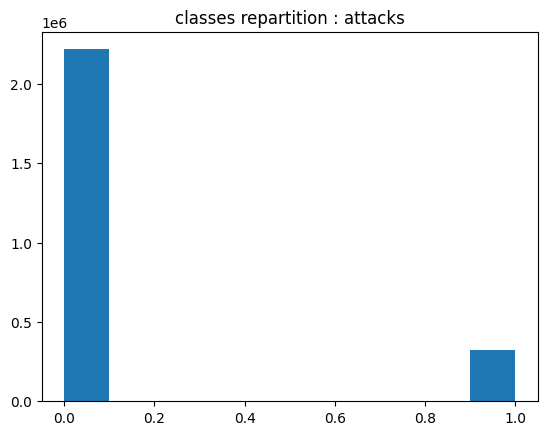

In [8]:
plt.hist(unsw_nb15_all_df['Label'])
plt.title('classes repartition : attacks')
plt.show()

## 2- Construire un Network

Nous proposons d'utiliser le dataset equilibré pour  la suite de notre analyse.

In [9]:
# Step 3: Create unique identifiers for each node
df =unsw_nb15_all_df
df['source_node'] = unsw_nb15_all_df['srcip'].astype(str) + ':' + unsw_nb15_all_df['sport'].astype(str)
df['destination_node'] = unsw_nb15_all_df['dstip'].astype(str) + ':' + unsw_nb15_all_df['dsport'].astype(str)

# Step 4: Create a list of tuples representing the edges
edges = list(zip(df['source_node'], df['destination_node']))

# Step 5: Build the Network of all data
g = ig.Graph.TupleList(edges, directed=True)
print(g.summary())

# main_graph est la version simplifiée de g (sans les boucles et les arêtes multiples entre les mêmes nœuds)
main_graph = g.copy()
main_graph.simplify()
print(main_graph.summary())

IGRAPH DN-- 1112287 2540047 -- 
+ attr: name (v)
IGRAPH DN-- 1112287 1956252 -- 
+ attr: name (v)


In [10]:
# Personnaliser le style du graphe
visual_style = {}

# Taille de la fenêtre de visualisation
visual_style["bbox"] = (1200, 1200)
# Marge autour du graphe
visual_style["margin"] = 50

# Style des sommets
visual_style["vertex_size"] = 5  # Taille des sommets
visual_style["vertex_color"] = "blue"  # Couleur des sommets

# Style des arêtes
visual_style["edge_color"] = "grey"  # Couleur des arêtes
visual_style["edge_width"] = 1  # Épaisseur des arêtes

# Disposition des sommets dans l'espace 2D
# 'layout' peut être 'auto', 'graphopt','kk' (Kamada-Kaway), etc.
#visual_style["layout"] = main_graph.layout("graphopt")

# Afficher le graphe (trop grand pour être affiché)
#ig.plot(main_graph, **visual_style)

In [11]:
# Obtenir toutes les composantes connexes (pas seulement la plus grande)
all_components = main_graph.connected_components(mode='weak')
all_components.summary()


'Clustering with 1112287 elements and 21499 clusters'

In [12]:
# Affichage du nombre total de composantes
print(f"Nombre total de composantes connexes : {len(all_components)}")

# Pour obtenir la taille de chaque composante
component_sizes = all_components.sizes()
print("Tailles des composantes :")
print(component_sizes)

# Pour obtenir des sous-graphes pour certaines des plus grandes composantes
for i in range(5):  # Par exemple, pour les 5 plus grandes composantes
    component = main_graph.subgraph(all_components[i])
    print(f"Composante {i} a {len(component.vs)} sommets")


Nombre total de composantes connexes : 21499
Tailles des composantes :
[983518, 7, 1, 2, 80467, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 5, 2, 3, 2, 2, 6, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 3, 2, 2, 6, 3, 2, 2, 3, 3, 4, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 6, 2, 3, 2, 2, 2, 2, 2, 2, 7, 3, 2, 3, 2, 3, 3, 4, 2, 4, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 4, 5, 2, 5, 3, 2, 2, 2, 2, 3, 4, 2, 2, 2, 3, 3, 2, 4, 3, 2, 2, 3, 2, 2, 3, 2, 5, 2, 2, 4, 2, 2, 2, 3, 3, 2, 2, 2, 2, 4, 3, 2, 4, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 5, 2, 2, 3, 2, 4, 5, 4, 2, 5, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 4, 2, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 4, 2, 3, 3, 3, 3, 2, 2, 2, 2, 4, 3, 2, 2, 3, 2, 6, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 7, 2, 3, 5, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 4, 2, 3, 3, 3, 2, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 3, 2, 4, 2, 2, 4, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2

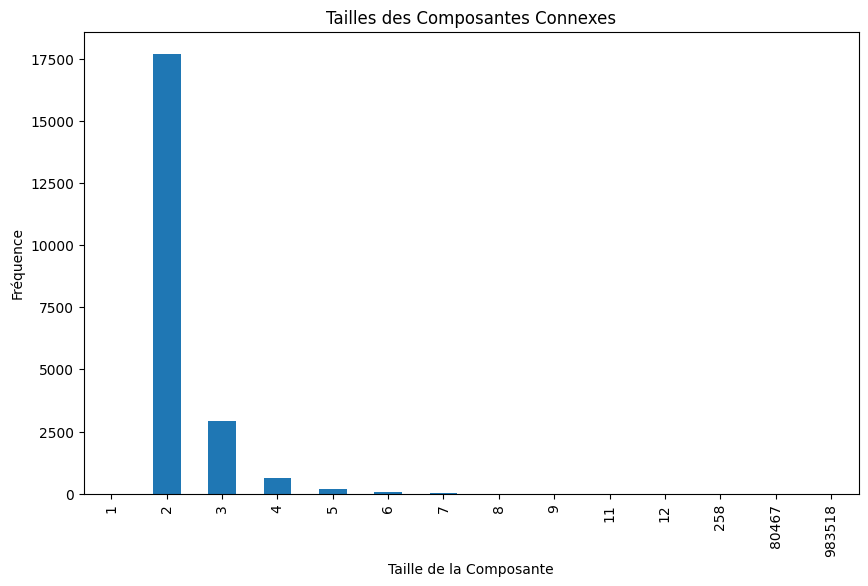

In [13]:
# Convertir en DataFrame pandas
data_df = pd.DataFrame(component_sizes, columns=['Size'])

# Grouper par taille et compter le nombre d'occurrences pour chaque taille
size_counts = data_df.groupby('Size').size()

# Tracer le graphique
plt.figure(figsize=(10, 6))  # Vous pouvez ajuster la taille du graphique selon vos besoins
size_counts.plot(kind='bar')  # Utiliser un graphique en barres pour représenter les fréquences
plt.title('Tailles des Composantes Connexes')
plt.xlabel('Taille de la Composante')
plt.ylabel('Fréquence')
plt.show()

Composante 0: 1923955 lignes, Répartition des labels :
Composante 4: 569286 lignes, Répartition des labels :
Composante 5148: 265 lignes, Répartition des labels :
Composante 787: 16 lignes, Répartition des labels :
Composante 722: 10 lignes, Répartition des labels :


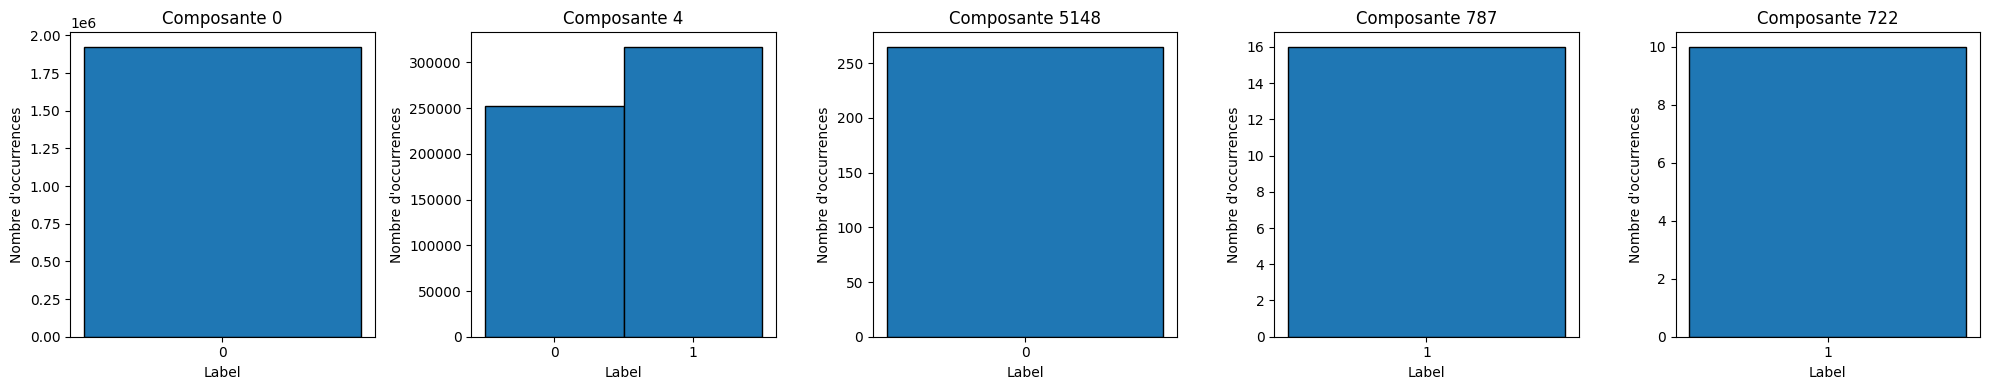

In [14]:
# Obtenir la taille de chaque composante et les trier par ordre décroissant
component_sizes = all_components.sizes()
sorted_component_indices = sorted(range(len(component_sizes)), key=lambda k: component_sizes[k], reverse=True)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Crée une grille 1x5 pour les graphiques

for idx, i in enumerate(sorted_component_indices[:5]):
    component = main_graph.subgraph(all_components[i])
    component_vertex_ids = component.vs['name']

    component_df = df[(df['source_node'].isin(component_vertex_ids)) & (df['destination_node'].isin(component_vertex_ids))]
    
    print(f"Composante {i}: {len(component_df)} lignes, Répartition des labels :")

    # Tracer l'histogramme dans le subplot correspondant
    axes[idx].hist(component_df['Label'], bins=np.arange(component_df['Label'].min(), component_df['Label'].max() + 1.5) - 0.5, edgecolor='black')
    axes[idx].set_xticks(np.arange(component_df['Label'].min(), component_df['Label'].max() + 1))
    axes[idx].set_xlabel('Label')
    axes[idx].set_ylabel('Nombre d\'occurrences')
    axes[idx].set_title(f'Composante {i}')

plt.tight_layout()  # Ajuste automatiquement les sous-graphiques pour qu'ils s'insèrent dans la figure
plt.show()


In [15]:
df['attack_cat'].value_counts()

attack_cat
Generic             215481
Exploits             44525
 Fuzzers             19195
DoS                  16353
 Reconnaissance      12228
 Fuzzers              5051
Analysis              2677
Backdoor              1795
Reconnaissance        1759
 Shellcode            1288
Backdoors              534
Shellcode              223
Worms                  174
Name: count, dtype: int64

Composante 0: 1923955 lignes, Répartition des labels :
[nan]
Composante 4: 569286 lignes, Répartition des labels :
['Exploits' 'Reconnaissance' 'DoS' 'Generic' 'Shellcode' nan 'Fuzzers'
 'Worms' 'Backdoors' 'Analysis' 'Backdoor']
Composante 5148: 265 lignes, Répartition des labels :
[nan]
Composante 787: 16 lignes, Répartition des labels :
['DoS']
Composante 722: 10 lignes, Répartition des labels :
['Generic' 'Exploits' 'DoS']


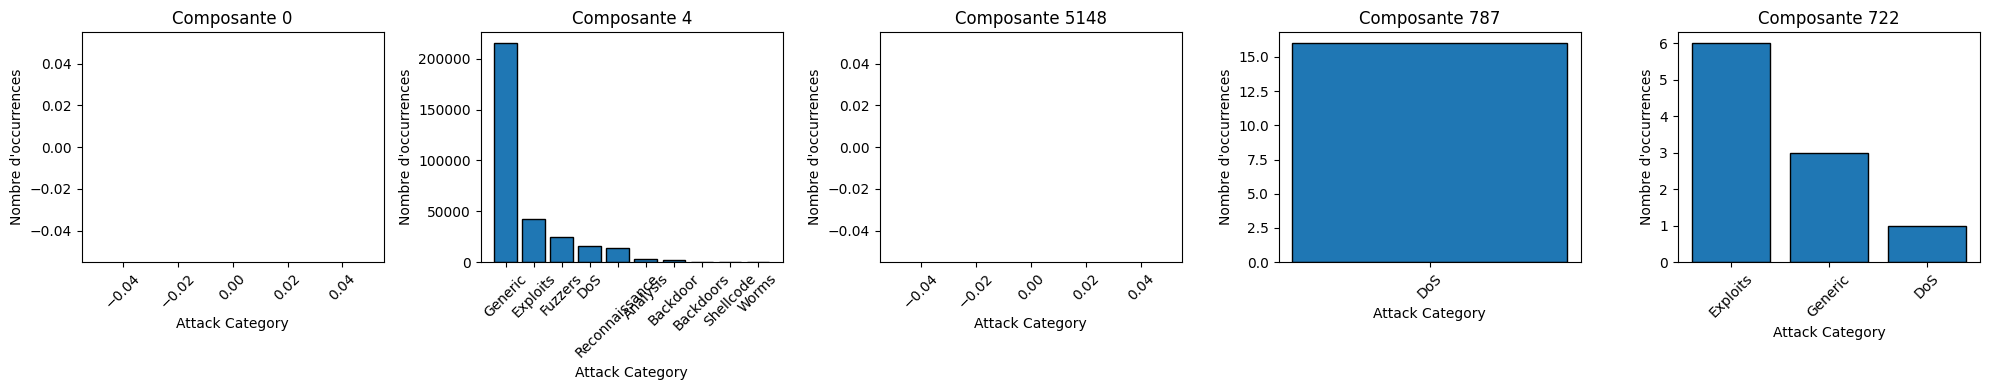

In [16]:
# Obtenir la taille de chaque composante et les trier par ordre décroissant
component_sizes = all_components.sizes()
sorted_component_indices = sorted(range(len(component_sizes)), key=lambda k: component_sizes[k], reverse=True)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Crée une grille 1x5 pour les graphiques


for idx, i in enumerate(sorted_component_indices[:5]):
    component = main_graph.subgraph(all_components[i])
    component_vertex_ids = component.vs['name']

    component_df = df[(df['source_node'].isin(component_vertex_ids)) & (df['destination_node'].isin(component_vertex_ids))]
    
    print(f"Composante {i}: {len(component_df)} lignes, Répartition des labels :")

    # Obtenir le compte de chaque catégorie unique
    # Créer une copie explicite de component_df pour éviter SettingWithCopyWarning
    component_df = component_df.copy()

    # Maintenant, vous pouvez modifier component_df sans soulever l'avertissement
    component_df['attack_cat'] = component_df['attack_cat'].str.strip()
    cat_counts = component_df['attack_cat'].value_counts()
    print(component_df['attack_cat'].unique())

    # Tracer un histogramme de type bar pour chaque catégorie
    axes[idx].bar(cat_counts.index, cat_counts.values, edgecolor='black')
    axes[idx].set_xlabel('Attack Category')
    axes[idx].set_ylabel('Nombre d\'occurrences')
    axes[idx].set_title(f'Composante {i}')
    axes[idx].tick_params(axis='x', rotation=45)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité

plt.tight_layout()  # Ajuste automatiquement les sous-graphiques pour qu'ils s'insèrent dans la figure
plt.show()

On constate qu'il y'a tous les types d'attaques dans 4. Mais la repartition est desequilibré.

In [17]:
# Obtenir l'indice de la 2ème plus grande composante
second_largest_component_index = sorted_component_indices[1]

# Créer un sous-graphe pour la 4ème plus grande composante
second_largest_component = main_graph.subgraph(all_components[second_largest_component_index])

# Obtenir les identifiants des sommets de la 4ème plus grande composante
second_largest_component_vertex_ids = second_largest_component.vs['name']

# Filtrer le DataFrame pour ne conserver que les lignes correspondant à la 4ème plus grande composante
df_largest_component = df[(df['source_node'].isin(second_largest_component_vertex_ids)) & (df['destination_node'].isin(second_largest_component_vertex_ids))]

# Vous pouvez maintenant utiliser `df_fourth_largest_component` pour vos analyses
print(f"La plus grande composante connexe retenu contient {len(df_largest_component)} lignes")
print(second_largest_component.summary())

La plus grande composante connexe retenu contient 569286 lignes
IGRAPH DN-- 80467 97217 -- 
+ attr: name (v)


In [18]:
# Obtenir l'indice de la 2ème plus grande composante
first_largest_component_index = sorted_component_indices[0]

# Créer un sous-graphe pour la 4ème plus grande composante
first_largest_component = main_graph.subgraph(all_components[second_largest_component_index])

# Obtenir les identifiants des sommets de la 4ème plus grande composante
first_largest_component_vertex_ids = first_largest_component.vs['name']

# Filtrer le DataFrame pour ne conserver que les lignes correspondant à la 4ème plus grande composante
df_first_largest_component = df[(df['source_node'].isin(first_largest_component_vertex_ids)) & (df['destination_node'].isin(first_largest_component_vertex_ids))]

# Vous pouvez maintenant utiliser `df_fourth_largest_component` pour vos analyses
print(f"La plus grande composante connexe retenu contient {len(df_first_largest_component)} lignes")
df_first_largest_component.head()

La plus grande composante connexe retenu contient 569286 lignes


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label,source_node,destination_node
21,175.45.176.2,23357,149.171.126.16,80,tcp,FIN,0.240139,918,25552,62,...,2,2,1,1,1,1,Exploits,1,175.45.176.2:23357,149.171.126.16:80
22,175.45.176.0,13284,149.171.126.16,80,tcp,FIN,2.390390,1362,268,254,...,2,2,1,1,1,1,Reconnaissance,1,175.45.176.0:13284,149.171.126.16:80
39,175.45.176.2,13792,149.171.126.16,5555,tcp,FIN,0.175190,8168,268,254,...,1,1,1,1,1,1,Exploits,1,175.45.176.2:13792,149.171.126.16:5555
40,175.45.176.2,26939,149.171.126.10,80,tcp,FIN,0.190600,844,268,254,...,1,1,1,1,1,1,Exploits,1,175.45.176.2:26939,149.171.126.10:80
57,175.45.176.0,39500,149.171.126.15,80,tcp,FIN,0.177449,1214,268,254,...,2,1,1,1,1,1,DoS,1,175.45.176.0:39500,149.171.126.15:80


In [19]:
# Personnaliser le style du graphe
visual_style = {}

# Taille de la fenêtre de visualisation
visual_style["bbox"] = (1200, 1200)
# Marge autour du graphe
visual_style["margin"] = 50

# Style des sommets
visual_style["vertex_size"] = 5  # Taille des sommets
visual_style["vertex_color"] = "blue"  # Couleur des sommets

# Style des arêtes
visual_style["edge_color"] = "grey"  # Couleur des arêtes
visual_style["edge_width"] = 1  # Épaisseur des arêtes

# Disposition des sommets dans l'espace 2D
# 'layout' peut être 'auto', 'graphopt','kk' (Kamada-Kaway), etc.
#visual_style["layout"] = second_largest_component.layout("graphopt")

# Afficher le graphe
#ig.plot(second_largest_component, **visual_style)

In [20]:
df_largest_component.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label,source_node,destination_node
21,175.45.176.2,23357,149.171.126.16,80,tcp,FIN,0.240139,918,25552,62,...,2,2,1,1,1,1,Exploits,1,175.45.176.2:23357,149.171.126.16:80
22,175.45.176.0,13284,149.171.126.16,80,tcp,FIN,2.390390,1362,268,254,...,2,2,1,1,1,1,Reconnaissance,1,175.45.176.0:13284,149.171.126.16:80
39,175.45.176.2,13792,149.171.126.16,5555,tcp,FIN,0.175190,8168,268,254,...,1,1,1,1,1,1,Exploits,1,175.45.176.2:13792,149.171.126.16:5555
40,175.45.176.2,26939,149.171.126.10,80,tcp,FIN,0.190600,844,268,254,...,1,1,1,1,1,1,Exploits,1,175.45.176.2:26939,149.171.126.10:80
57,175.45.176.0,39500,149.171.126.15,80,tcp,FIN,0.177449,1214,268,254,...,2,1,1,1,1,1,DoS,1,175.45.176.0:39500,149.171.126.15:80


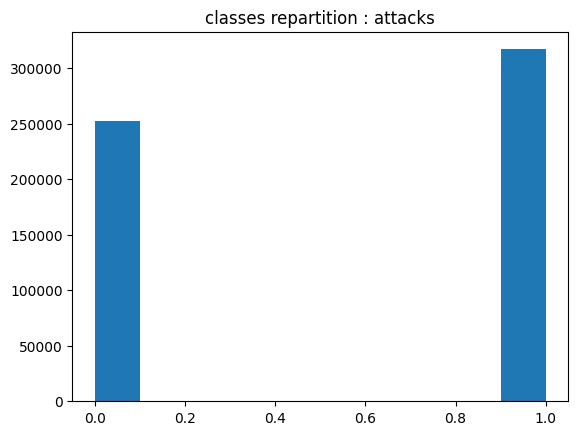

In [21]:
plt.hist(df_largest_component['Label'])
plt.title('classes repartition : attacks')
plt.show()

['Exploits' 'Reconnaissance' 'DoS' 'Generic' 'Shellcode' 'Normal'
 'Fuzzers' 'Worms' 'Backdoors' 'Analysis' 'Backdoor']


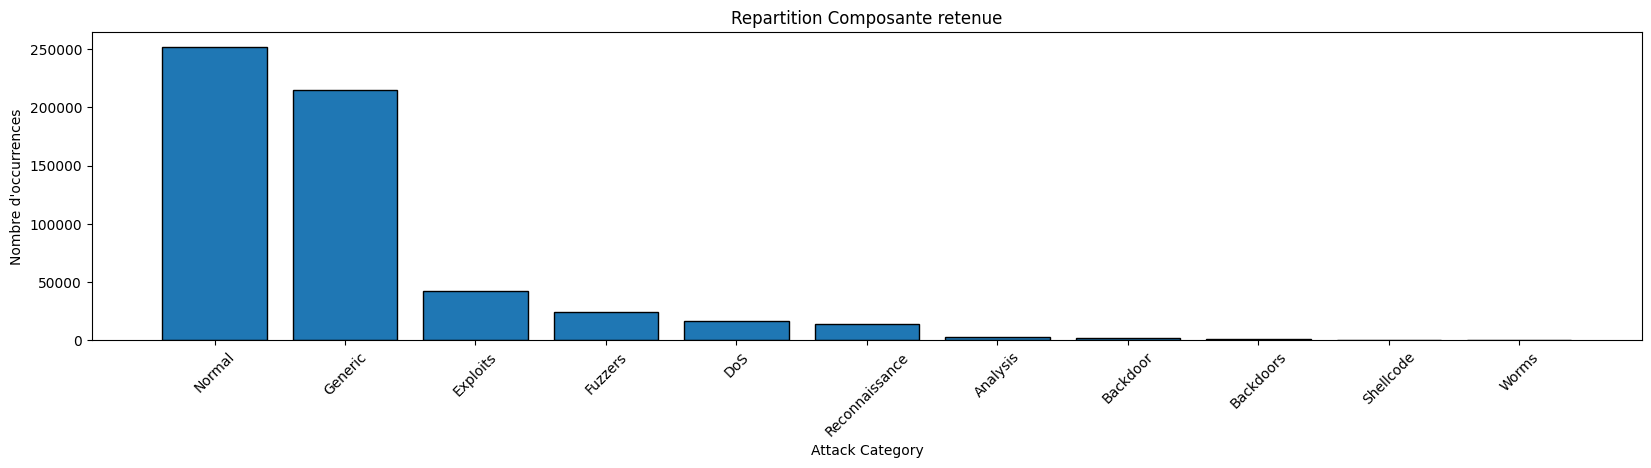

In [22]:
fig, axes = plt.subplots( figsize=(20, 4))
component_df = df_largest_component.copy()
component_df['attack_cat'] = component_df['attack_cat'].fillna('Normal')

# Maintenant, vous pouvez modifier component_df sans soulever l'avertissement
component_df['attack_cat'] = component_df['attack_cat'].str.strip()
cat_counts = component_df['attack_cat'].value_counts()
print(component_df['attack_cat'].unique())

# Tracer un histogramme de type bar pour chaque catégorie
axes.bar(cat_counts.index, cat_counts.values, edgecolor='black')
axes.set_xlabel('Attack Category')
axes.set_ylabel('Nombre d\'occurrences')
axes.set_title(f'Repartition Composante retenue')
axes.tick_params(axis='x', rotation=45)  #

# Repartition en fonction des types d'attaques

on peut remarque à partir de l'image en haut que:
> On retrouve toutes les toutes d'attaques dans la composante connexe choisie.

>la répartition des classes pour les différents attaques n'est pas équilibrée.


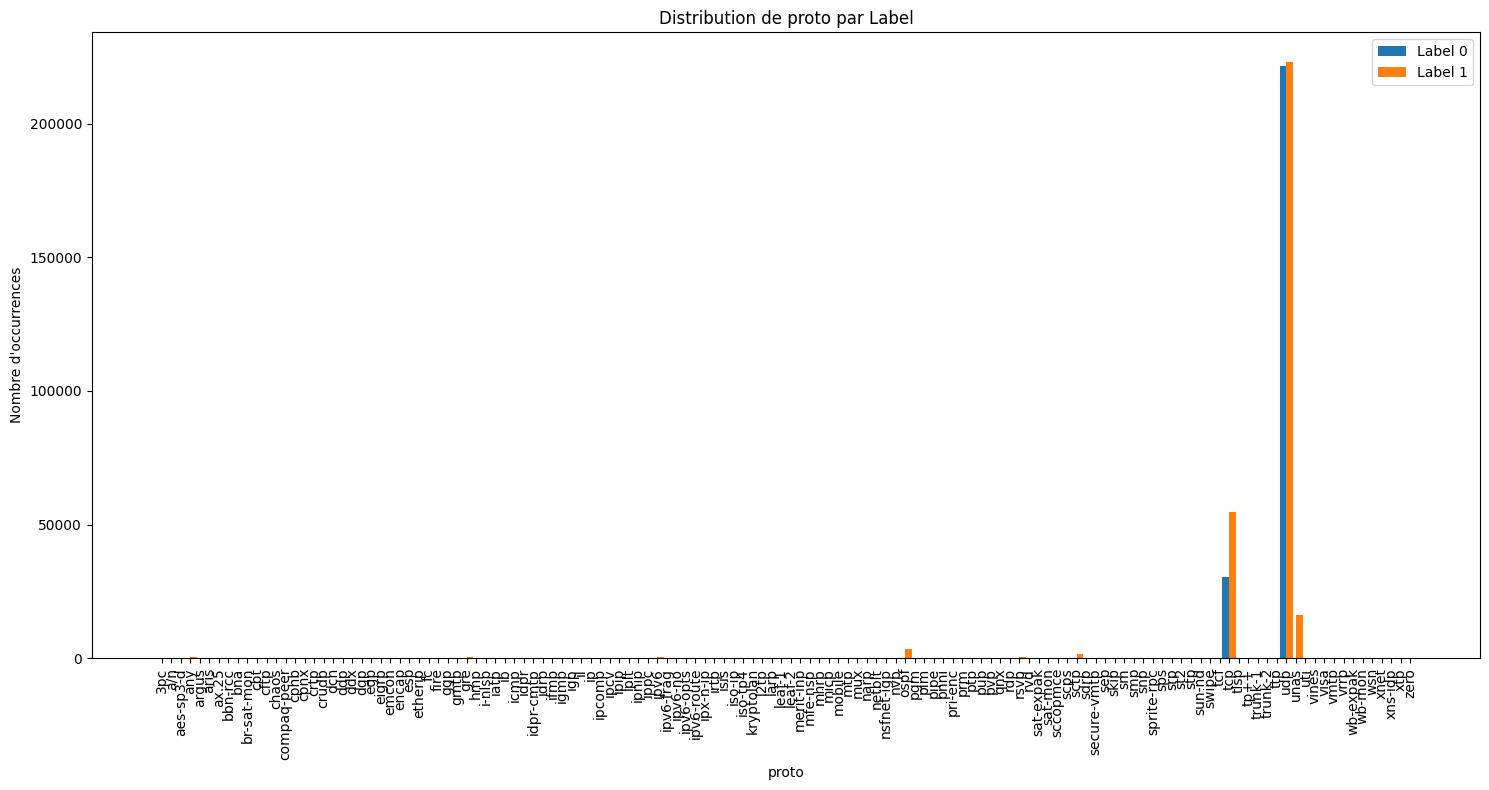

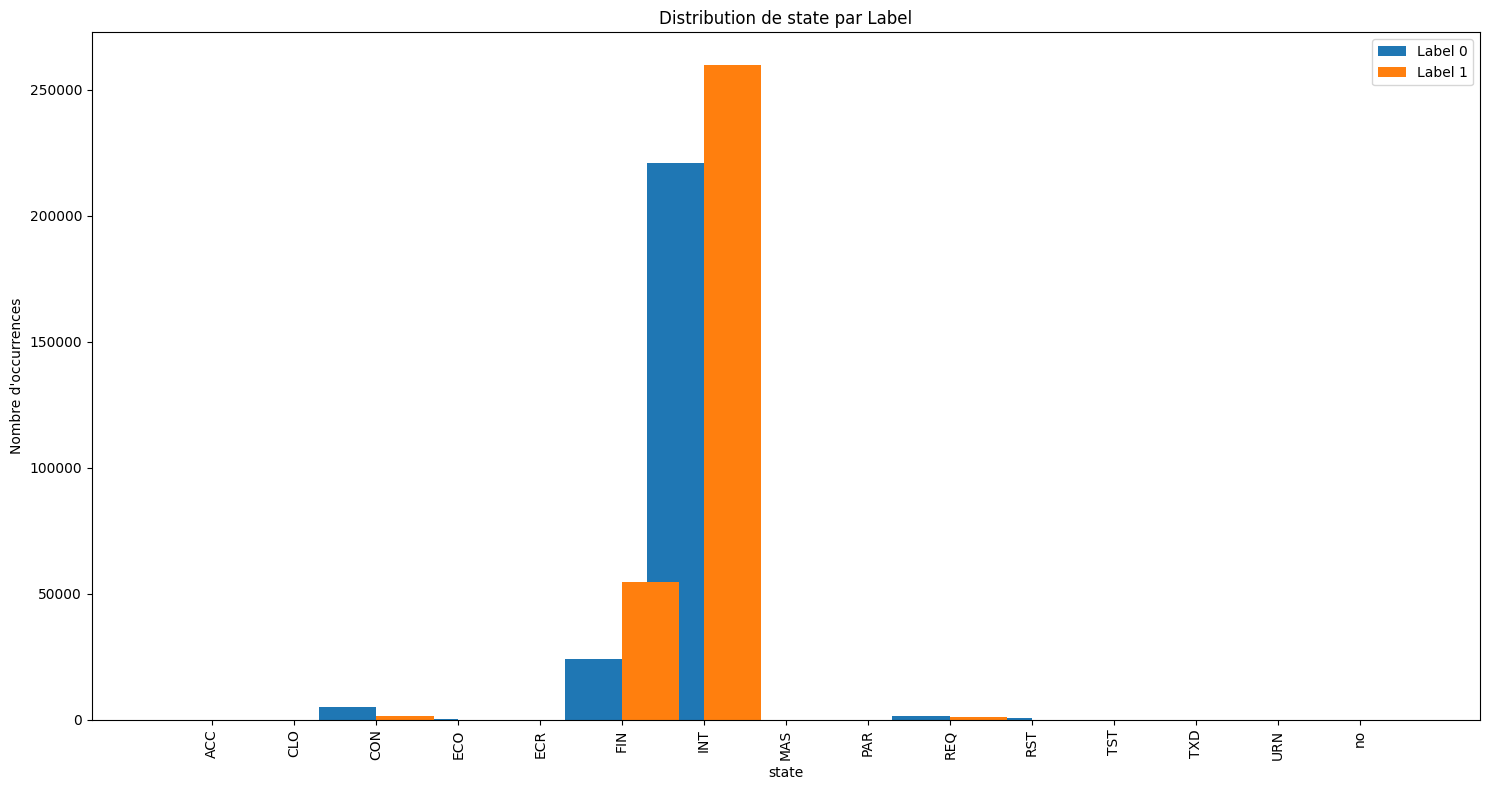

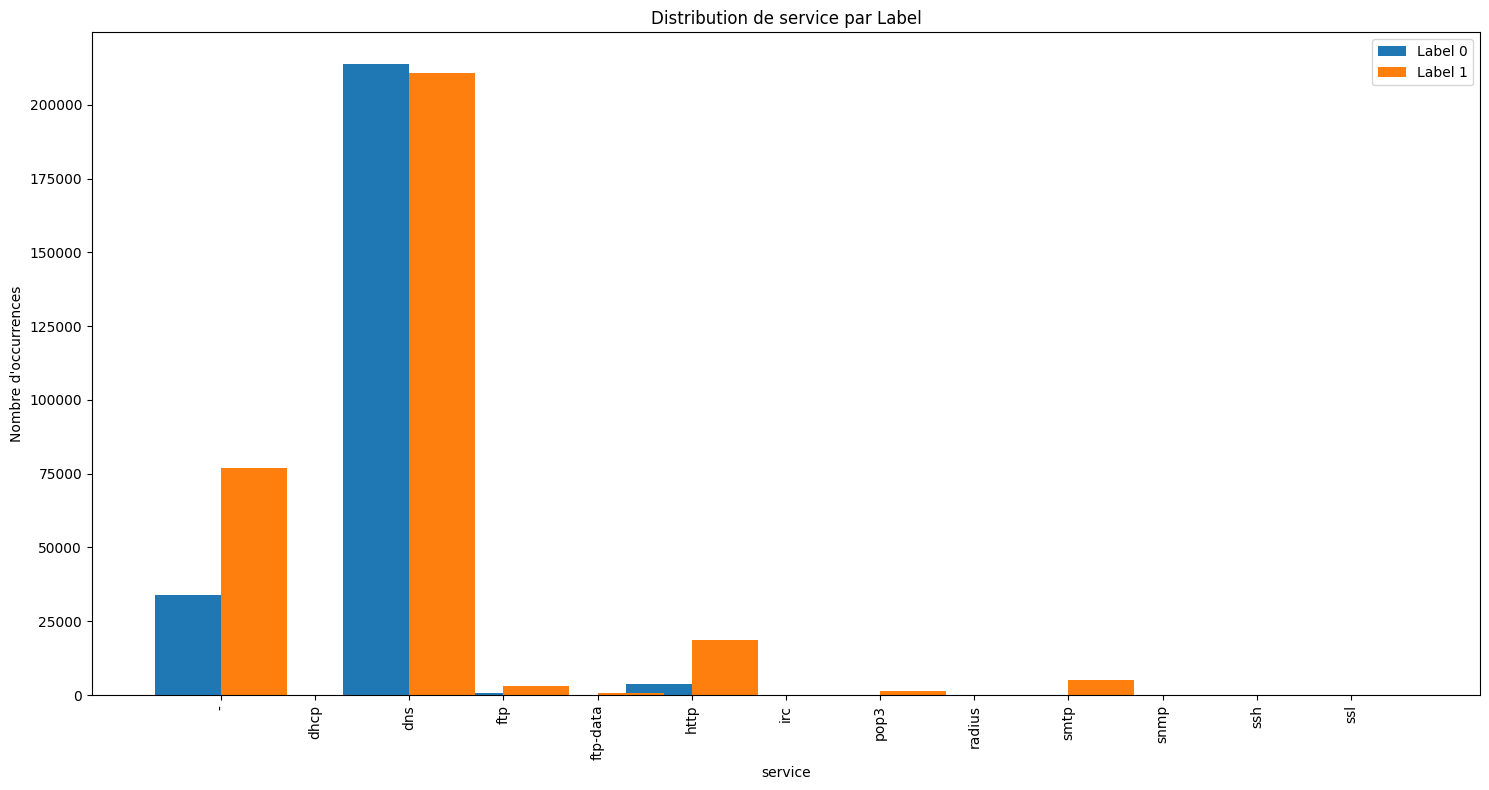

In [23]:

# Vos variables nominales
var_nominal = ['proto', 'state', 'service']

# Pour chaque variable nominale, tracer la distribution des labels
for var in var_nominal:
    plt.figure(figsize=(15, 8))
    
    # Calculer le nombre d'occurrences pour chaque catégorie et label
    counts = df_largest_component.groupby([var, 'Label']).size().unstack(fill_value=0)
    
    # Préparation des indices pour le tracé des barres
    index = np.arange(len(counts.index))
    bar_width = 0.35*2
    # Tracé des barres
    plt.bar(index - bar_width/2, counts[0], bar_width, label='Label 0')
    plt.bar(index + bar_width/2, counts[1], bar_width, label='Label 1')
    
    # Ajout de titres et de labels
    plt.xlabel(var)
    plt.ylabel('Nombre d\'occurrences')
    plt.title(f'Distribution de {var} par Label')
    plt.xticks(index, counts.index, rotation=90)  # Rotation à 90 degrés pour plus de clarté
    plt.legend()
    
    # Ajustement de l'espacement pour éviter le chevauchement
    plt.tight_layout()
    
    # Affichage du graphique
    plt.show()


# 3- Faire une première prédiction (classifications)

## Preprocessing

In [24]:
# Liste des variables
variables_int = ['ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_dport_ltm', 'ct_src_ltm', 'ct_dst_ltm', 
             'ct_srv_dst', 'ct_srv_src', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_state_ttl', 'ackdat', 
             'synack', 'tcprtt', 'dintpkt', 'sintpkt', 'ltime', 'stime', 'djit', 'sjit', 'res_bdy_len', 
             'trans_depth', 'dmeansz', 'smeansz', 'dtcpb', 'stcpb', 'dwin', 'swin', 'dpkts', 'spkts', 
             'dload', 'sload', 'dloss', 'sloss', 'dttl', 'sttl', 'dbytes', 'dur']

# Vérifier les types de ces colonnes

df_largest_component.loc[:, 'ct_ftp_cmd'] = pd.to_numeric(df_largest_component['ct_ftp_cmd'], errors='coerce')


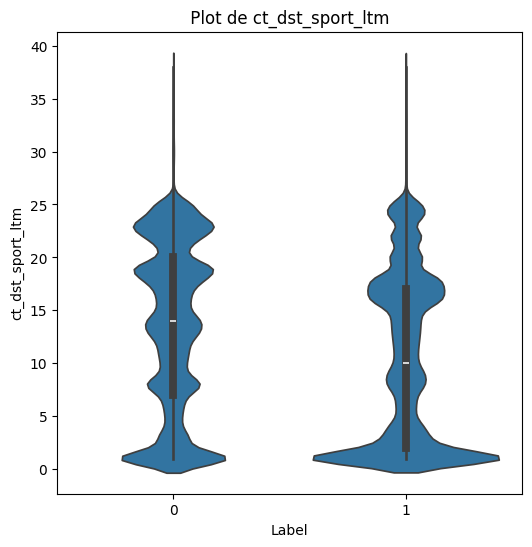

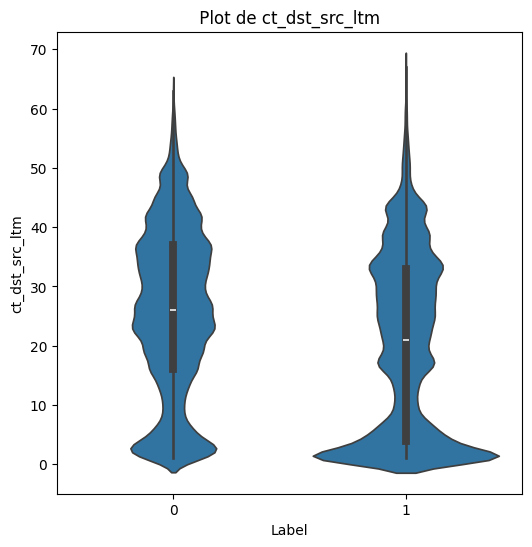

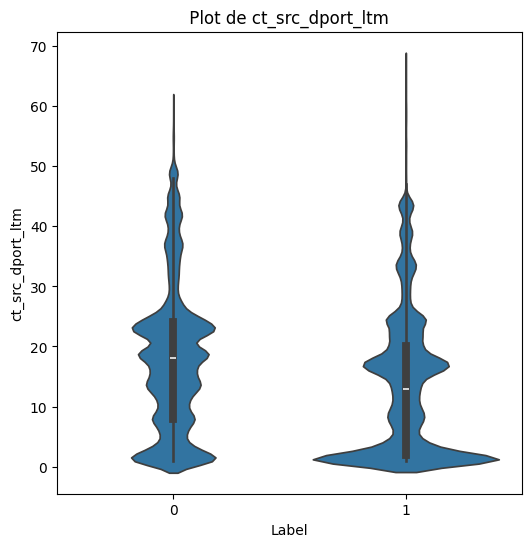

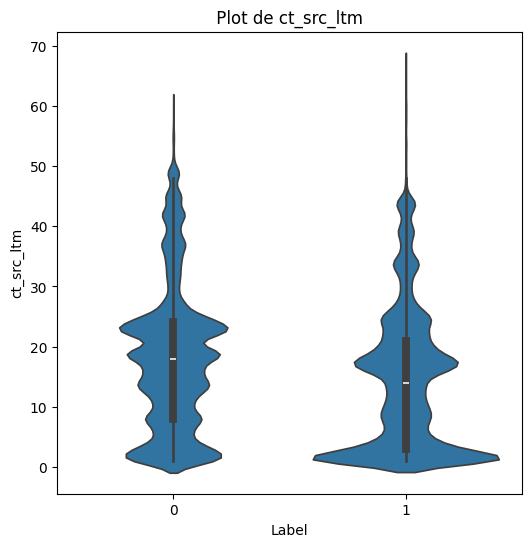

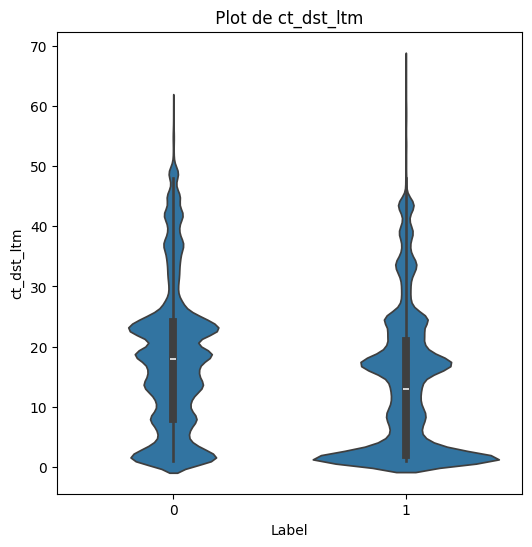

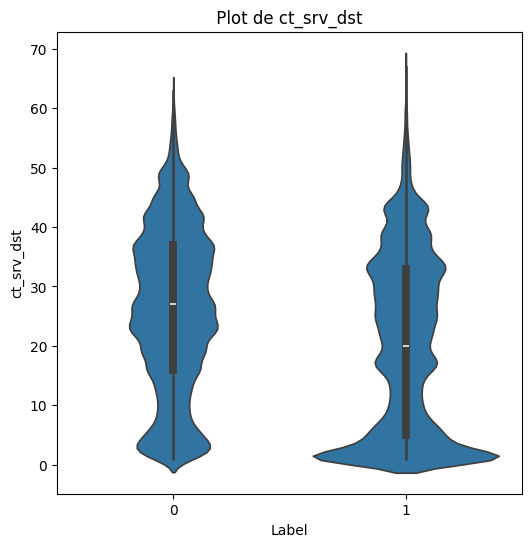

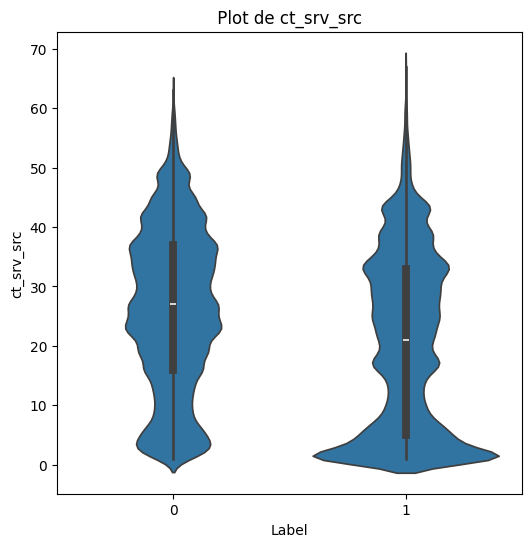

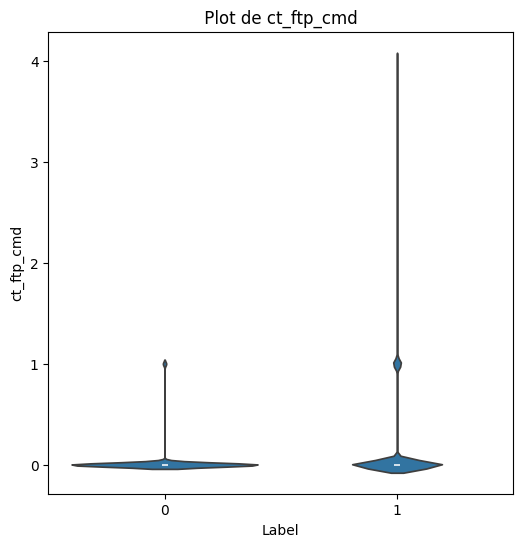

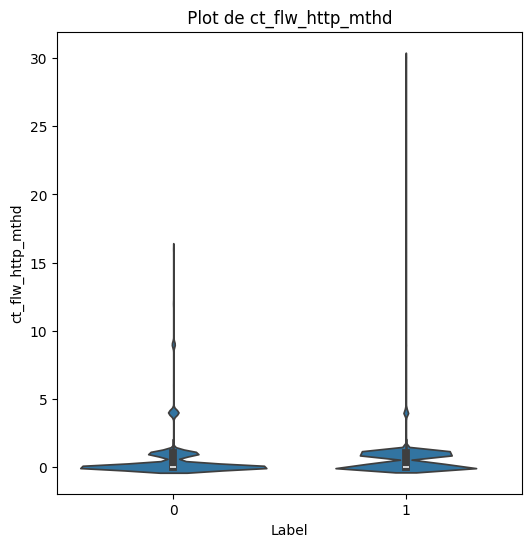

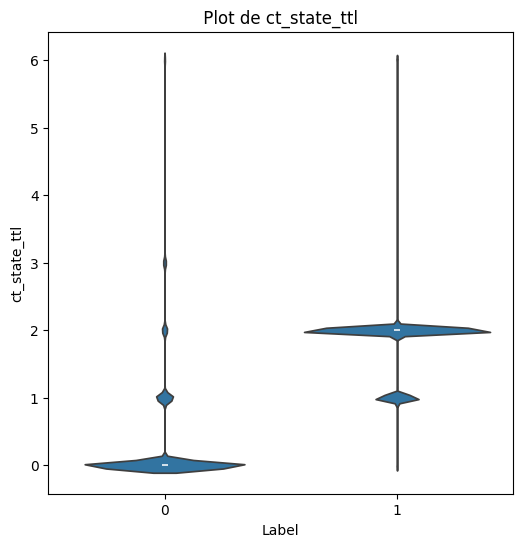

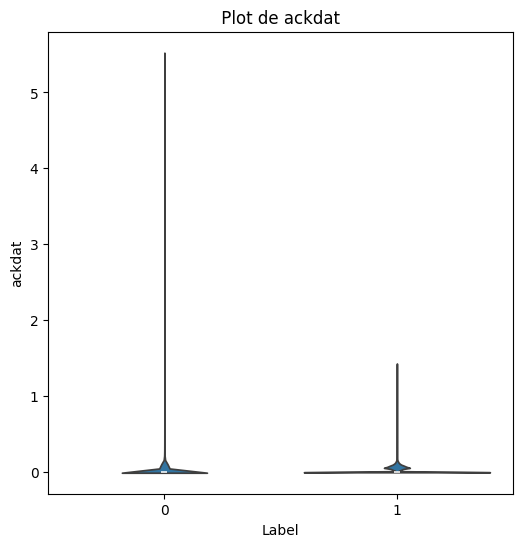

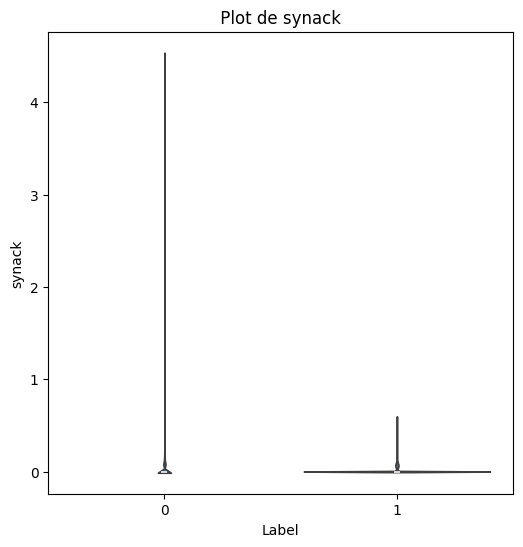

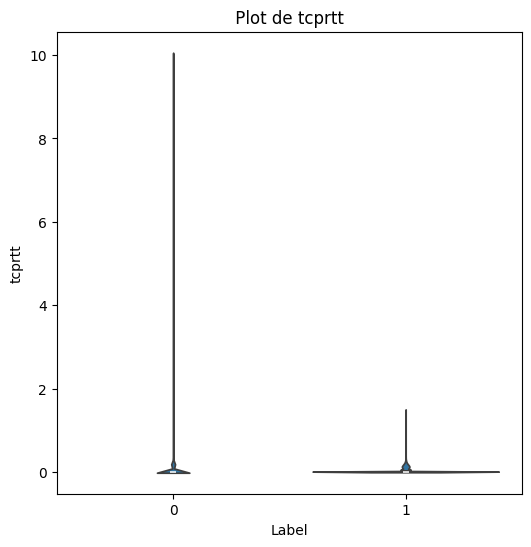

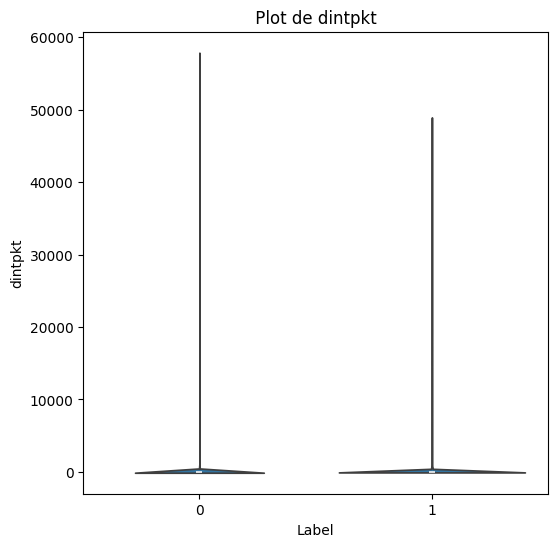

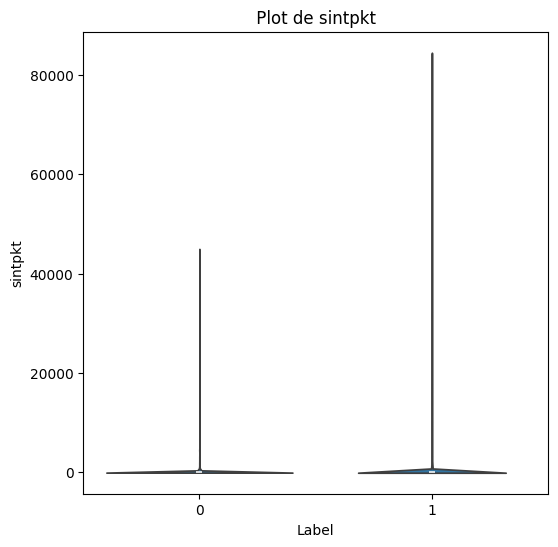

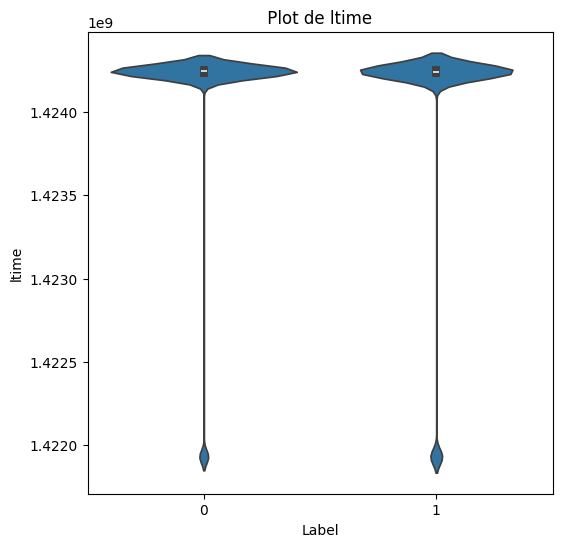

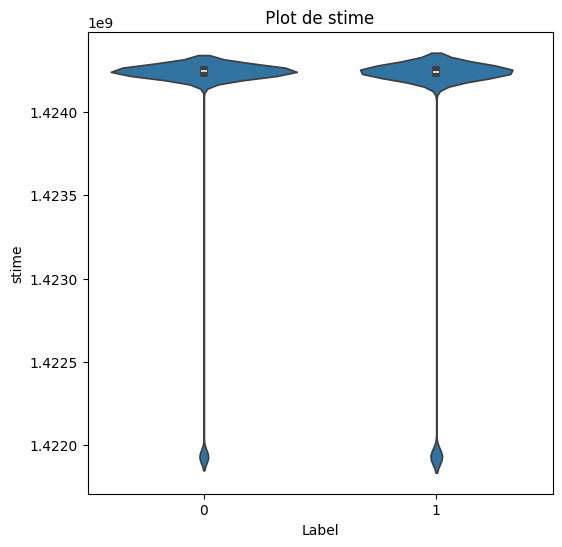

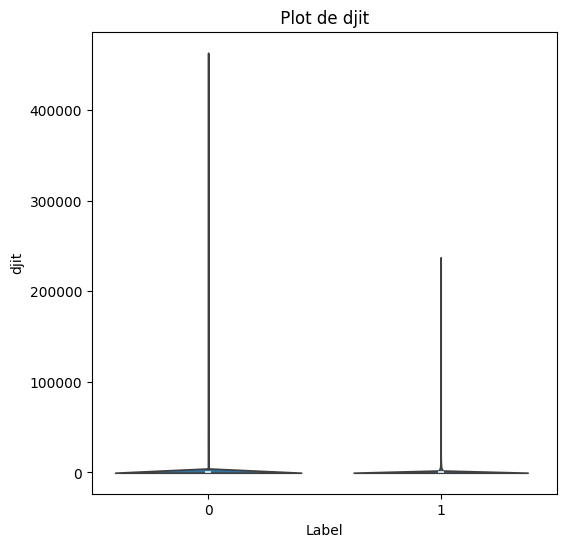

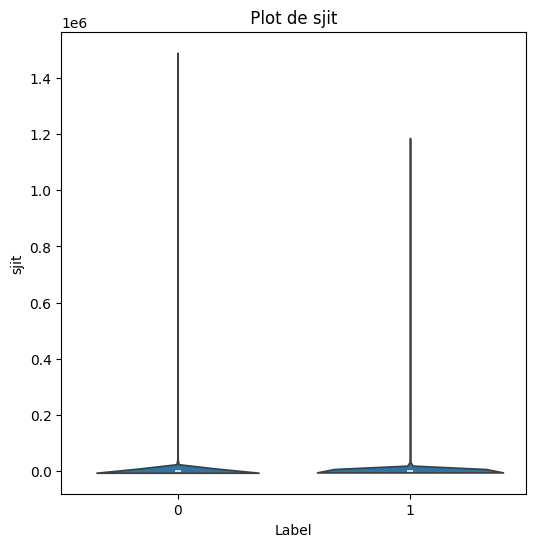

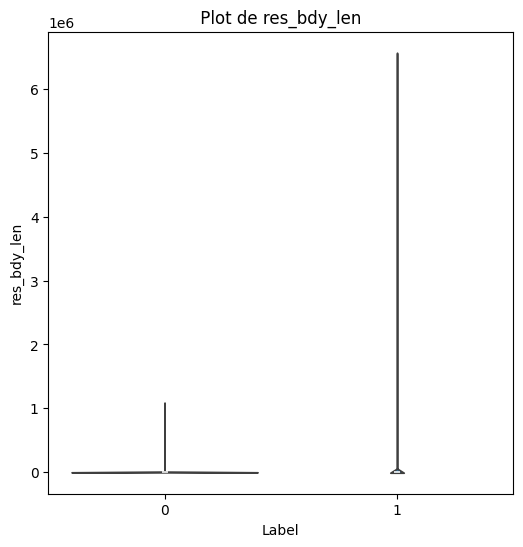

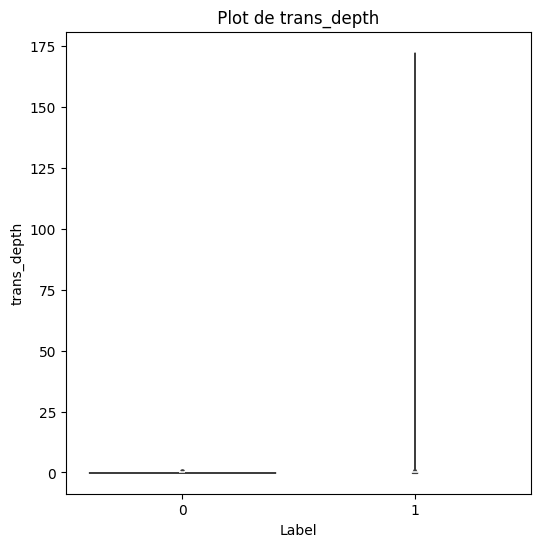

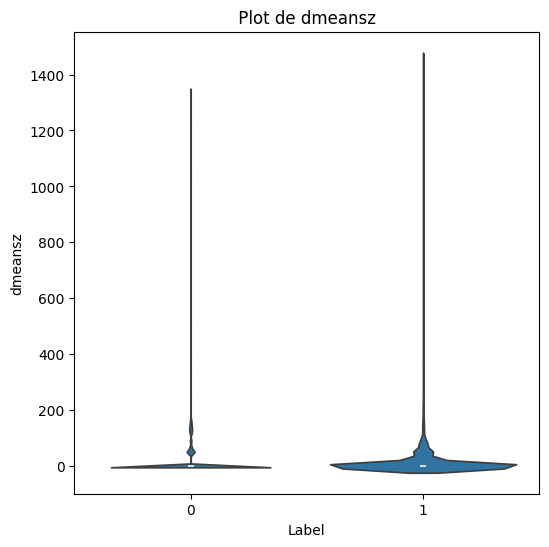

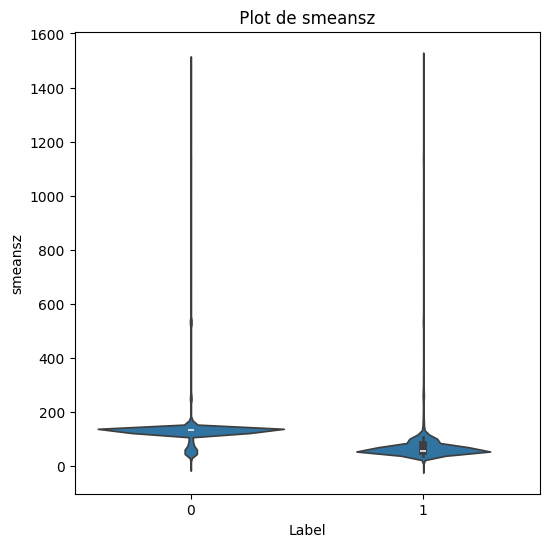

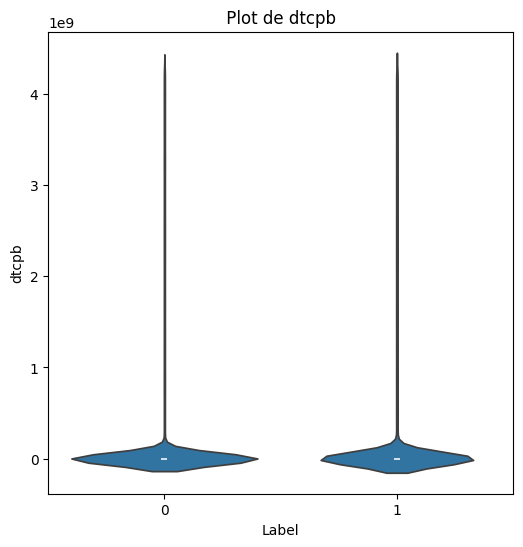

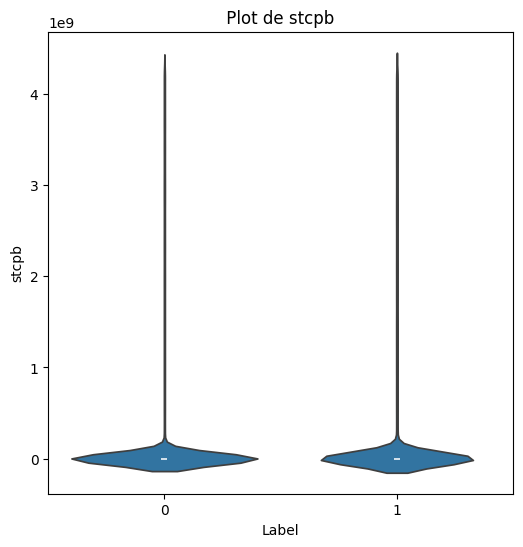

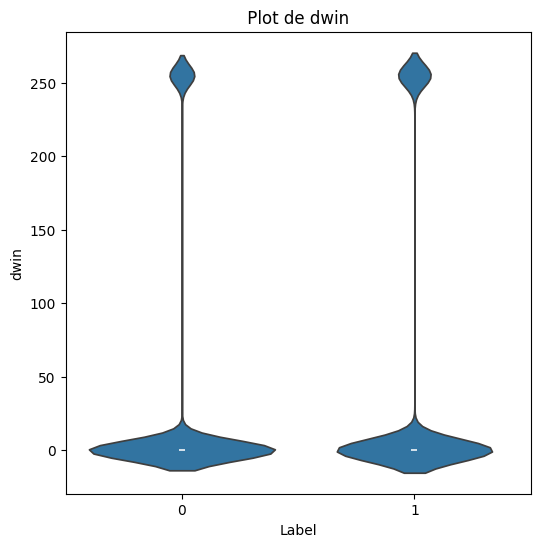

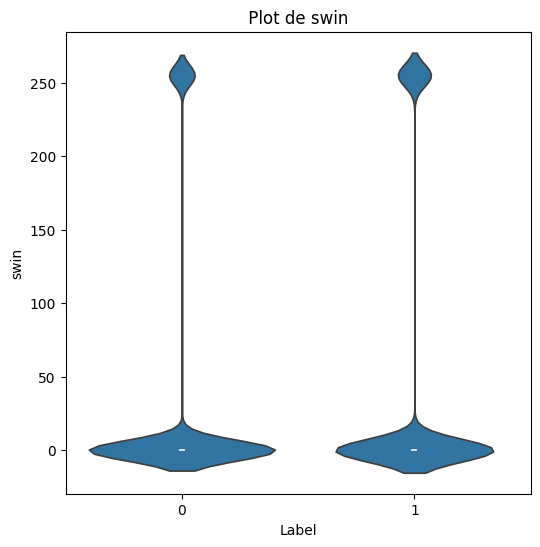

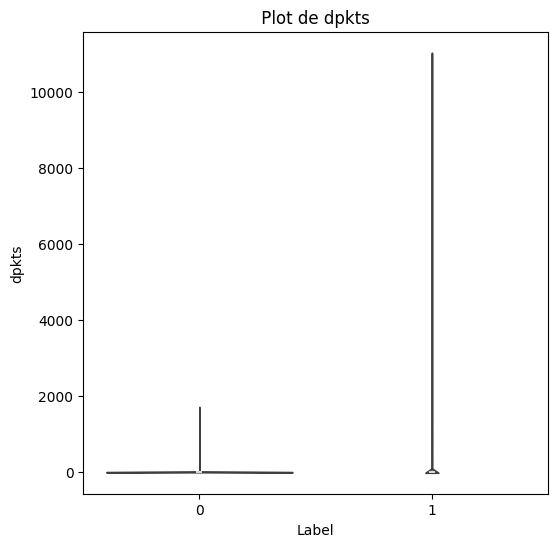

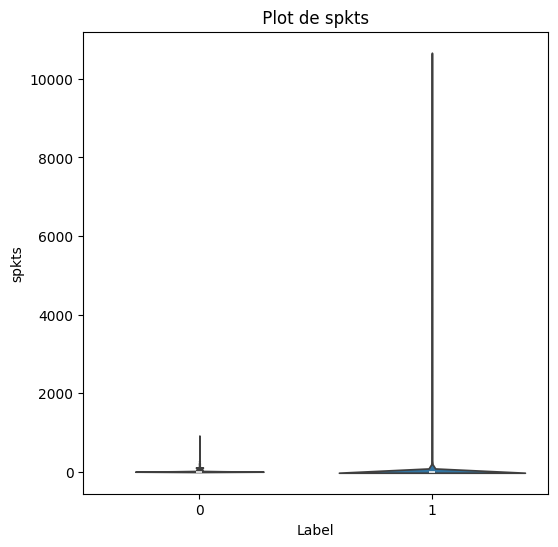

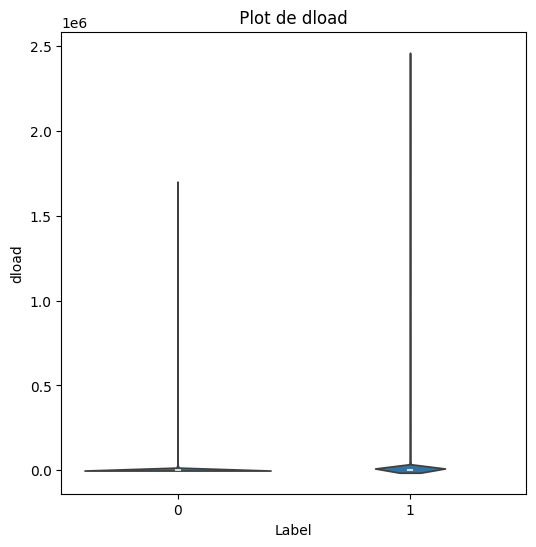

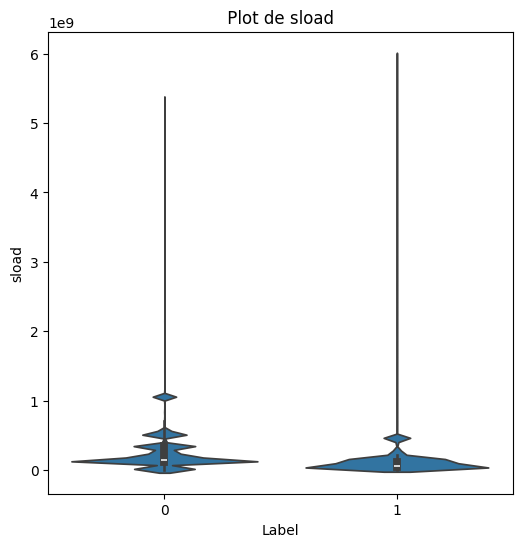

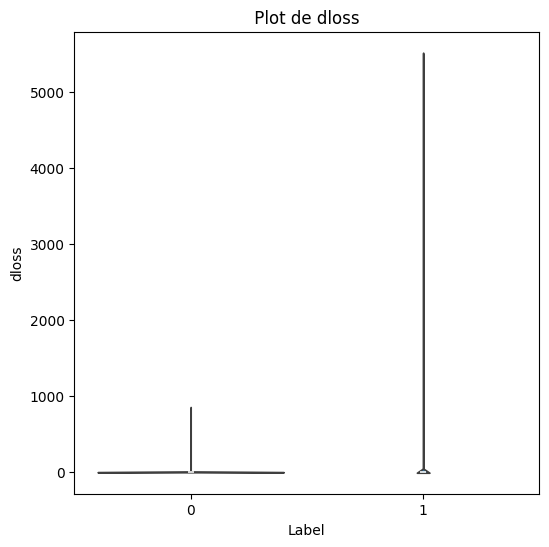

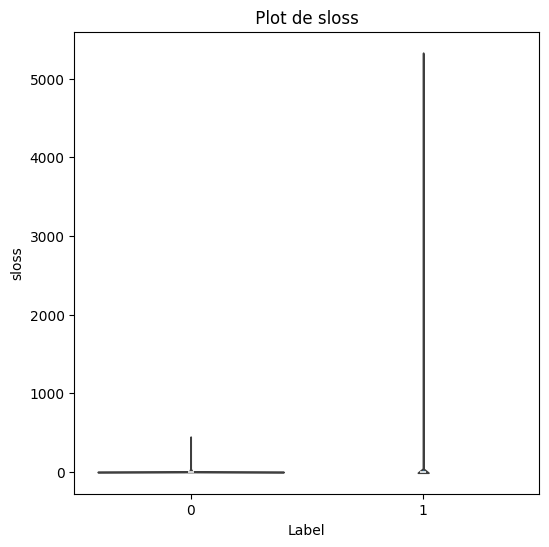

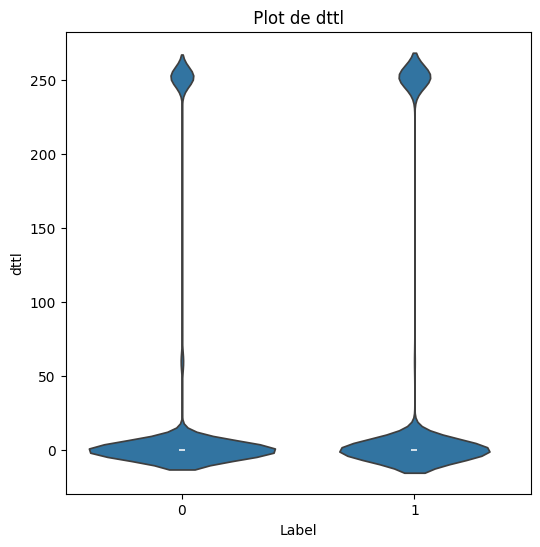

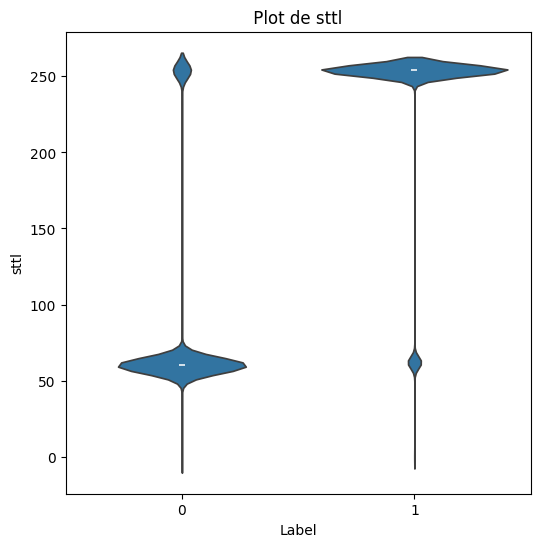

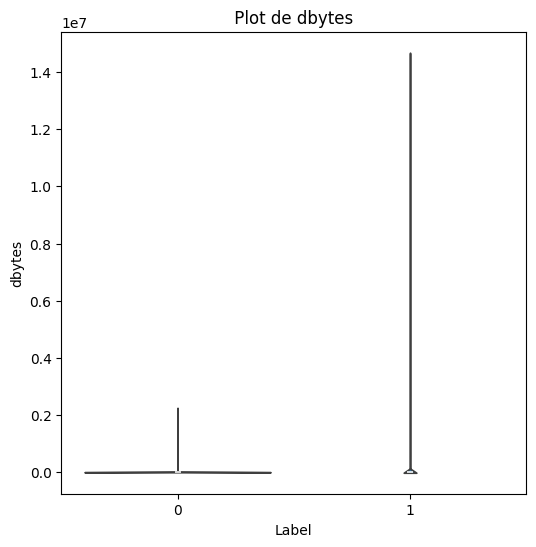

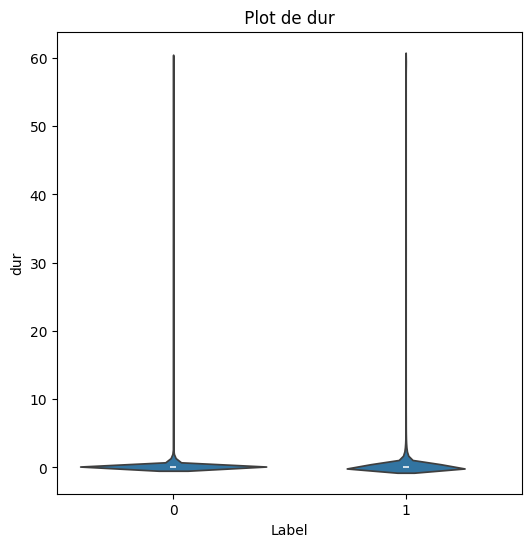

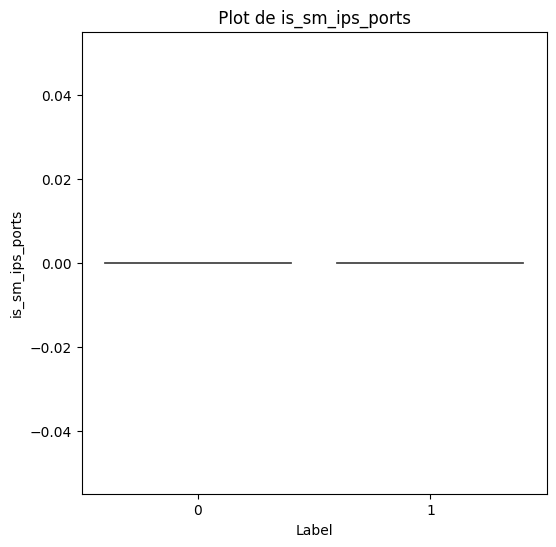

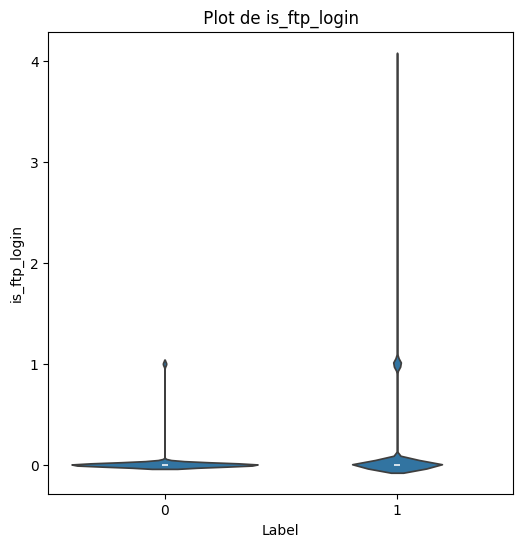

In [26]:
# Liste des variables à visualiser
variables_int = ['ct_dst_sport_ltm', 'ct_dst_src_ltm','ct_src_dport_ltm','ct_src_ltm','ct_dst_ltm','ct_srv_dst','ct_srv_src','ct_ftp_cmd','ct_flw_http_mthd','ct_state_ttl','ackdat','synack','tcprtt','dintpkt',
             'sintpkt','ltime','stime','djit','sjit','res_bdy_len','trans_depth','dmeansz','smeansz','dtcpb','stcpb','dwin','swin','dpkts','spkts','dload','sload','dloss','sloss','dttl','sttl','dbytes','dur','is_sm_ips_ports','is_ftp_login']

# Création d'un violon plot pour chaque variable
for var in variables_int:
    plt.figure(figsize=(6, 6))
    sns.violinplot(x='Label', y=var, data=df_largest_component)
    plt.title(f' Plot de {var} ')
    plt.show()


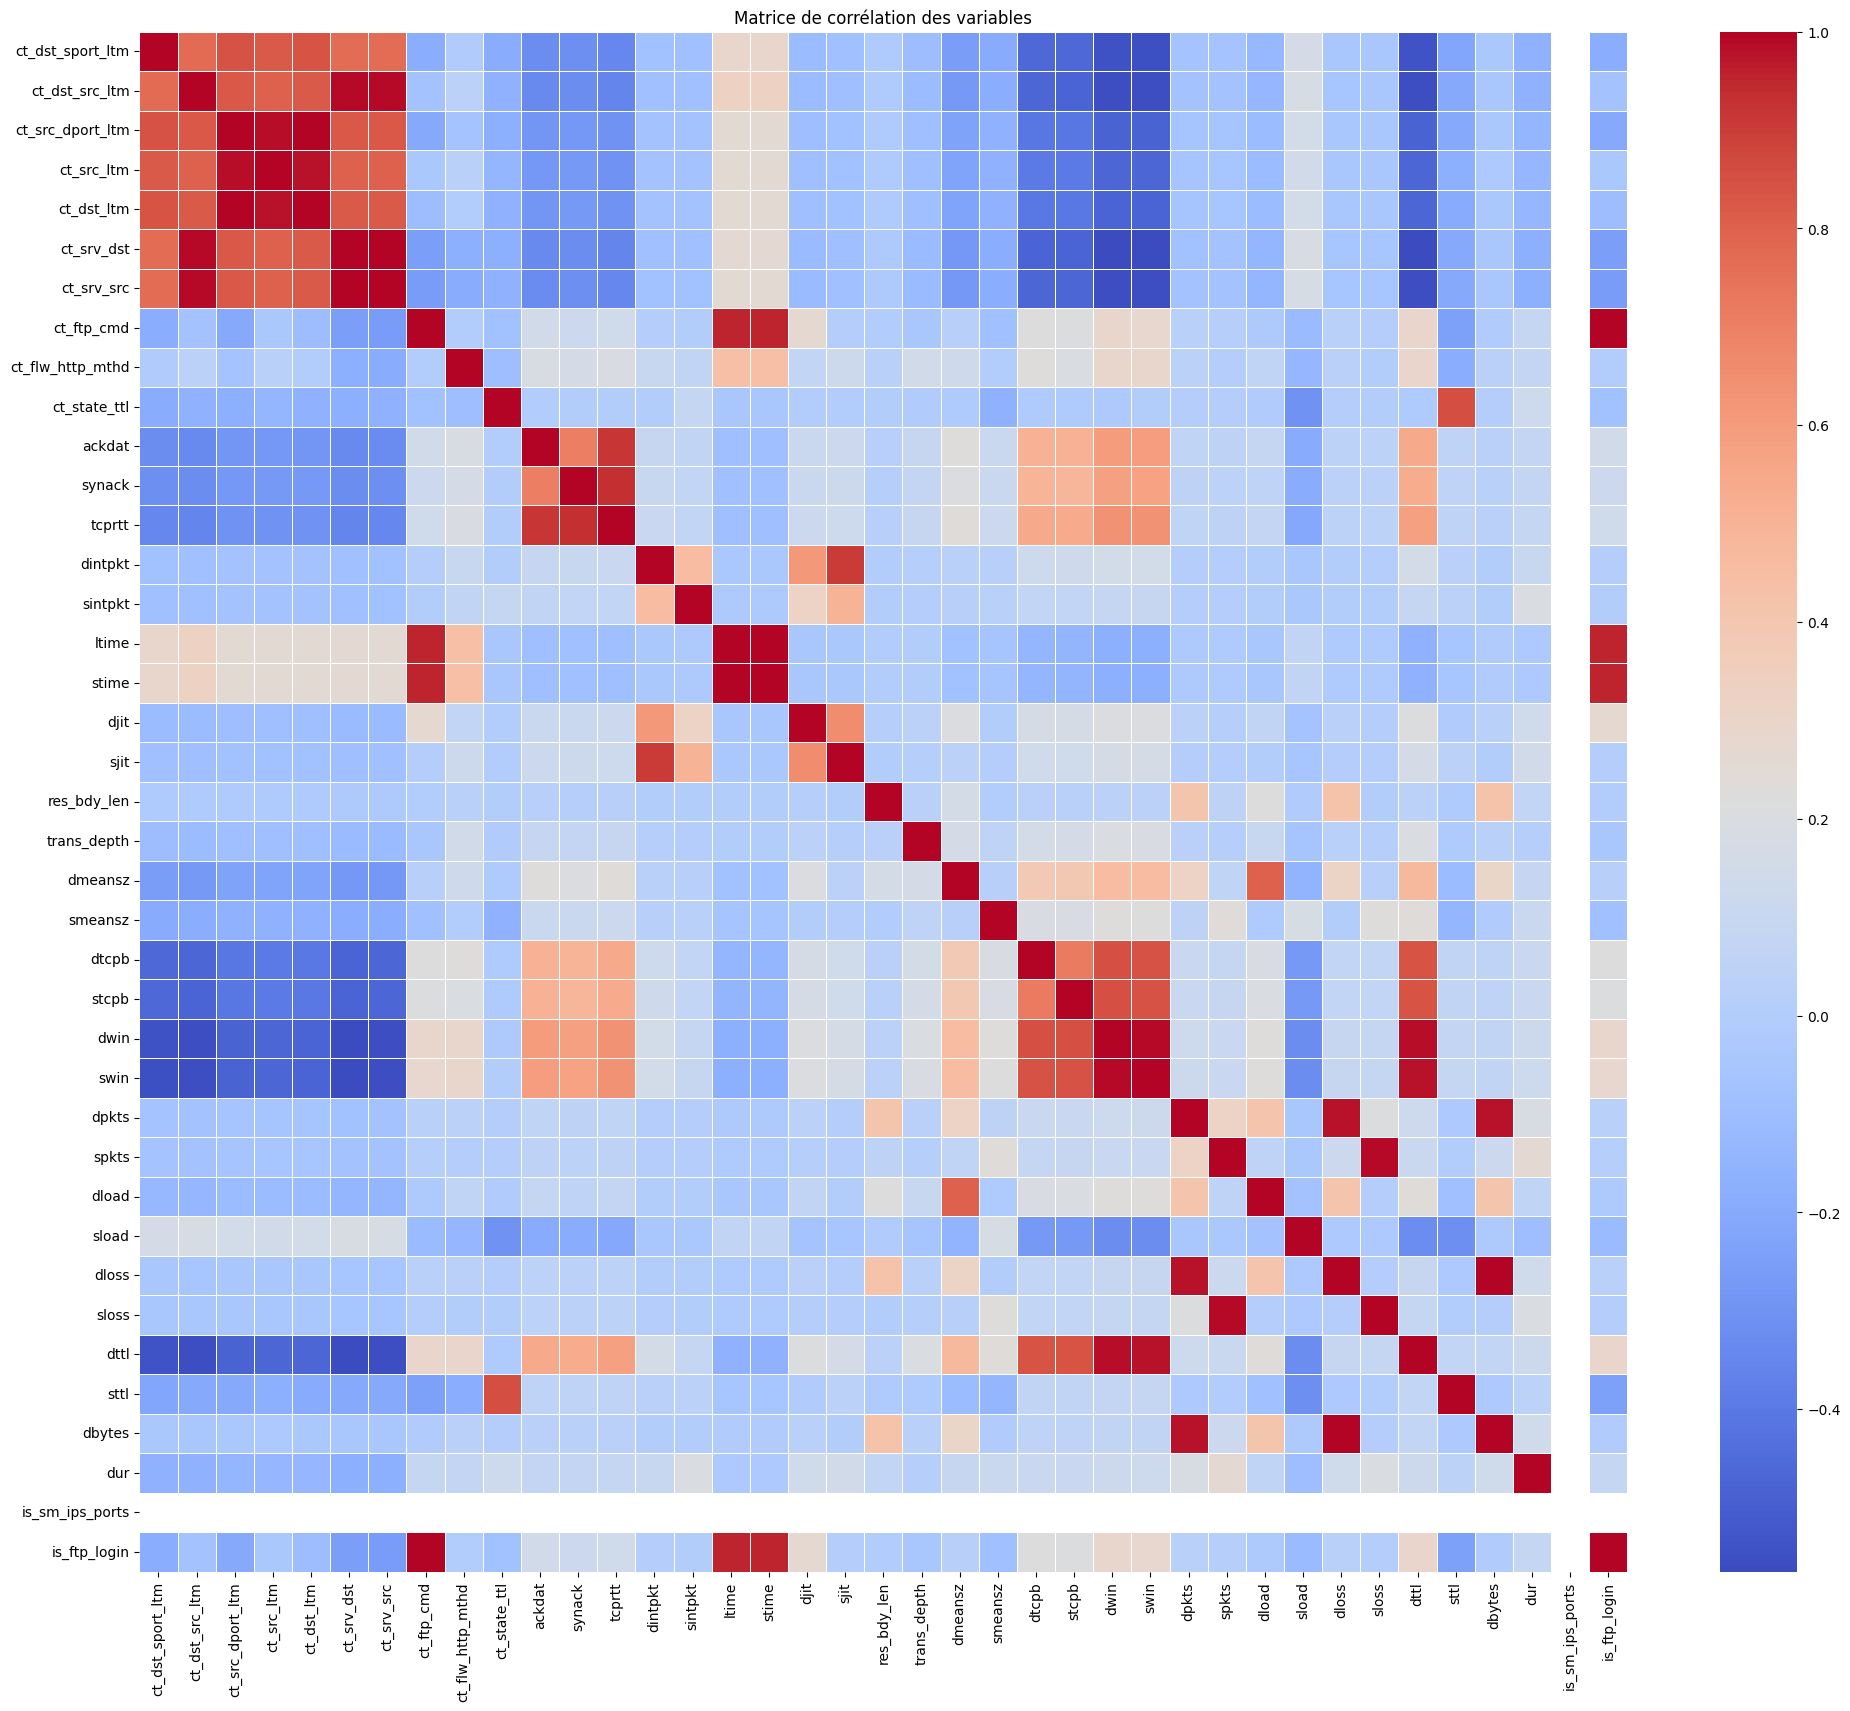

In [27]:

# Calcul de la matrice de corrélation
correlation_matrix = df_largest_component[variables_int].corr()

# Création de la carte de chaleur
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Matrice de corrélation des variables')
plt.show()

{'ct_src_ltm', 'tcprtt', 'ct_srv_src', 'sloss', 'dwin', 'ltime', 'is_ftp_login', 'dloss', 'swin', 'stime', 'ct_dst_ltm', 'sjit', 'ct_srv_dst', 'dttl', 'dbytes', 'sttl', 'ct_src_dport_ltm'}


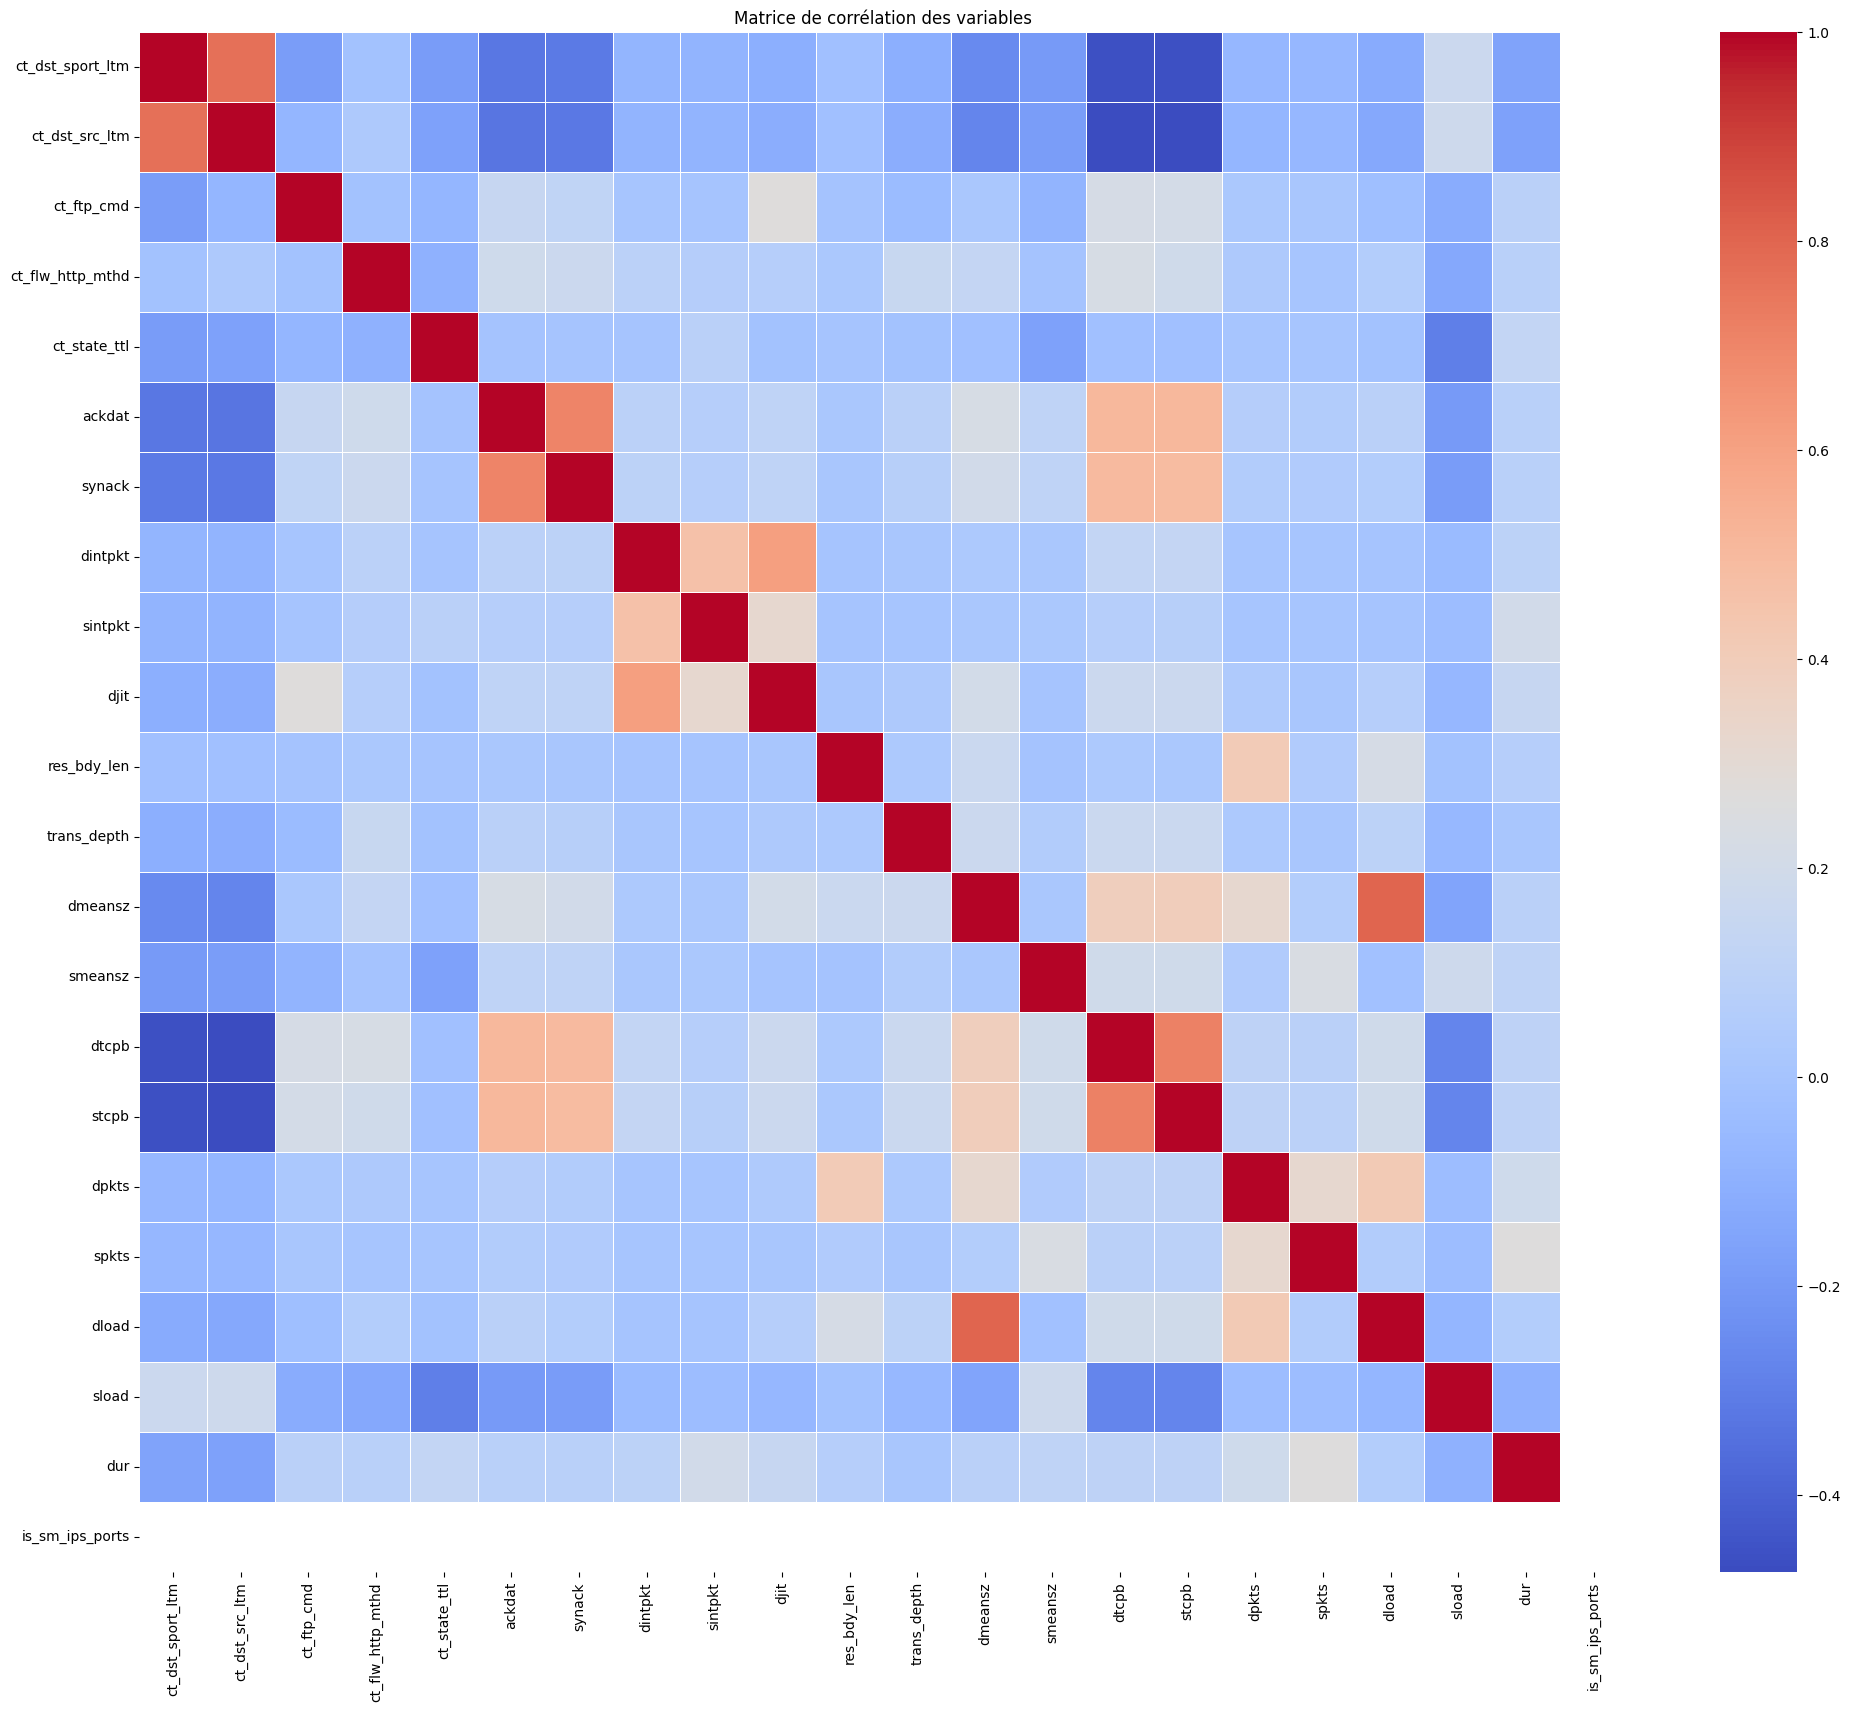

Index(['ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_state_ttl', 'ackdat', 'synack', 'dintpkt', 'sintpkt', 'djit',
       'res_bdy_len', 'trans_depth', 'dmeansz', 'smeansz', 'dtcpb', 'stcpb',
       'dpkts', 'spkts', 'dload', 'sload', 'dur', 'is_sm_ips_ports'],
      dtype='object')

In [28]:
# Calcul de la matrice de corrélation
corr_matrix = df_largest_component[variables_int].corr()

# Trouver les paires de variables fortement corrélées (au-dessus de 0.8)
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            # Si la corrélation est forte, ajouter l'un des deux à la liste des colonnes à supprimer
            to_drop.add(corr_matrix.columns[j])

# Afficher les paires de variables fortement corrélées
print(to_drop)

# Éliminer les variables fortement corrélées
df_largest_component_reduced = df_largest_component[variables_int].drop(columns=to_drop)

new_colonnes = df_largest_component_reduced.columns

# Calcul de la matrice de corrélation
correlation_matrix = df_largest_component_reduced.corr()

# Création de la carte de chaleur
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Matrice de corrélation des variables')
plt.show()

int_keep_columns = df_largest_component_reduced.columns
final_df = df_largest_component_reduced
final_df['Label'] = df_largest_component['Label']
# add nominal columns
final_df['proto'] = df_largest_component['proto']
final_df['state'] = df_largest_component['state']
final_df['service'] = df_largest_component['service']
int_keep_columns

In [29]:

# Initialisation du MinMaxScaler.
scaler = MinMaxScaler()

# Normalisation des colonnes numériques spécifiées dans variables.
final_df[int_keep_columns] = scaler.fit_transform(final_df[int_keep_columns])


final_df_for_attack = final_df
# drop label column
final_df_for_attack = final_df.drop(columns=['Label'])
#add attack column
final_df_for_attack['attack_cat'] = df_largest_component['attack_cat']

# Affichage des premières lignes du DataFrame normalisé pour vérifier.
final_df.head()


,ct_dst_sport_ltm,ct_dst_src_ltm,ct_ftp_cmd,ct_flw_http_mthd,ct_state_ttl,ackdat,synack,dintpkt,sintpkt,djit,...,dpkts,spkts,dload,sload,dur,is_sm_ips_ports,Label,proto,state,service
21,0.0,0.0,0.0,0.033333,0.166667,0.008154,0.001443,0.000166,0.000259,0.002471,...,0.002178,0.001127,0.333295,4.684439e-06,0.004002,0.0,1,tcp,FIN,http
22,0.0,0.0,0.0,0.033333,0.166667,0.008731,0.003969,0.008214,0.002176,0.002033,...,0.000545,0.001315,0.000306,7.070172e-07,0.039840,0.0,1,tcp,FIN,http
39,0.0,0.0,0.0,0.000000,0.166667,0.008369,0.001932,0.000577,0.000140,0.000103,...,0.000545,0.001315,0.004179,5.784349e-05,0.002920,0.0,1,tcp,FIN,-
40,0.0,0.0,0.0,0.033333,0.166667,0.008040,0.001404,0.000638,0.000220,0.000129,...,0.000545,0.000939,0.003841,5.327199e-06,0.003177,0.0,1,tcp,FIN,http
57,0.0,0.0,0.0,0.033333,0.166667,0.008146,0.001564,0.000590,0.000228,0.000134,...,0.000545,0.000939,0.004126,8.229146e-06,0.002958,0.0,1,tcp,FIN,http


In [30]:

final_df_for_attack['attack_cat'] = final_df_for_attack['attack_cat'].fillna('Normal')
# Maintenant, vous pouvez modifier component_df sans soulever l'avertissement
final_df_for_attack['attack_cat'] = final_df_for_attack['attack_cat'].str.strip()
print(final_df_for_attack['attack_cat'].unique())
final_df_for_attack.head()

['Exploits' 'Reconnaissance' 'DoS' 'Generic' 'Shellcode' 'Normal'
 'Fuzzers' 'Worms' 'Backdoors' 'Analysis' 'Backdoor']


,ct_dst_sport_ltm,ct_dst_src_ltm,ct_ftp_cmd,ct_flw_http_mthd,ct_state_ttl,ackdat,synack,dintpkt,sintpkt,djit,...,dpkts,spkts,dload,sload,dur,is_sm_ips_ports,proto,state,service,attack_cat
21,0.0,0.0,0.0,0.033333,0.166667,0.008154,0.001443,0.000166,0.000259,0.002471,...,0.002178,0.001127,0.333295,4.684439e-06,0.004002,0.0,tcp,FIN,http,Exploits
22,0.0,0.0,0.0,0.033333,0.166667,0.008731,0.003969,0.008214,0.002176,0.002033,...,0.000545,0.001315,0.000306,7.070172e-07,0.039840,0.0,tcp,FIN,http,Reconnaissance
39,0.0,0.0,0.0,0.000000,0.166667,0.008369,0.001932,0.000577,0.000140,0.000103,...,0.000545,0.001315,0.004179,5.784349e-05,0.002920,0.0,tcp,FIN,-,Exploits
40,0.0,0.0,0.0,0.033333,0.166667,0.008040,0.001404,0.000638,0.000220,0.000129,...,0.000545,0.000939,0.003841,5.327199e-06,0.003177,0.0,tcp,FIN,http,Exploits
57,0.0,0.0,0.0,0.033333,0.166667,0.008146,0.001564,0.000590,0.000228,0.000134,...,0.000545,0.000939,0.004126,8.229146e-06,0.002958,0.0,tcp,FIN,http,DoS


In [31]:
print(final_df_for_attack.isnull().sum())

ct_dst_sport_ltm         0
ct_dst_src_ltm           0
ct_ftp_cmd          534697
ct_flw_http_mthd    517135
ct_state_ttl             0
ackdat                   0
synack                   0
dintpkt                  0
sintpkt                  0
djit                     0
res_bdy_len              0
trans_depth              0
dmeansz                  0
smeansz                  0
dtcpb                    0
stcpb                    0
dpkts                    0
spkts                    0
dload                    0
sload                    0
dur                      0
is_sm_ips_ports          0
proto                    0
state                    0
service                  0
attack_cat               0
dtype: int64


In [32]:
# handle null values
# show the number of null values in each column
print(final_df.isnull().sum())

ct_dst_sport_ltm         0
ct_dst_src_ltm           0
ct_ftp_cmd          534697
ct_flw_http_mthd    517135
ct_state_ttl             0
ackdat                   0
synack                   0
dintpkt                  0
sintpkt                  0
djit                     0
res_bdy_len              0
trans_depth              0
dmeansz                  0
smeansz                  0
dtcpb                    0
stcpb                    0
dpkts                    0
spkts                    0
dload                    0
sload                    0
dur                      0
is_sm_ips_ports          0
Label                    0
proto                    0
state                    0
service                  0
dtype: int64


In [33]:
# drop columns with lots of null values 
final_df = final_df.drop(['ct_ftp_cmd'], axis=1)
final_df = final_df.drop(['ct_flw_http_mthd'], axis=1)
# 
final_df_for_attack = final_df_for_attack.drop(['ct_ftp_cmd'], axis=1)
final_df_for_attack = final_df_for_attack.drop(['ct_flw_http_mthd'], axis=1)

In [34]:
final_df.columns

Index(['ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_state_ttl', 'ackdat',
       'synack', 'dintpkt', 'sintpkt', 'djit', 'res_bdy_len', 'trans_depth',
       'dmeansz', 'smeansz', 'dtcpb', 'stcpb', 'dpkts', 'spkts', 'dload',
       'sload', 'dur', 'is_sm_ips_ports', 'Label', 'proto', 'state',
       'service'],
      dtype='object')

In [40]:

# Séparation des données en ensembles d'entraînement et de test
X = final_df.drop(columns='Label')
y = final_df['Label']

# Création de variables dummy pour les variables catégorielles
X_dummies = pd.get_dummies(X, drop_first=True)

# Séparation des données en ensembles d'entraînement et de test après avoir créé des variables dummy
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

# Entraînement du modèle SVM avec un noyau radial ('rbf' est le choix par défaut)
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = svm_model.predict(X_test)

# Évaluation du modèle
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[45626  4993]
 [  705 62534]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     50619
           1       0.93      0.99      0.96     63239

    accuracy                           0.95    113858
   macro avg       0.96      0.95      0.95    113858
weighted avg       0.95      0.95      0.95    113858



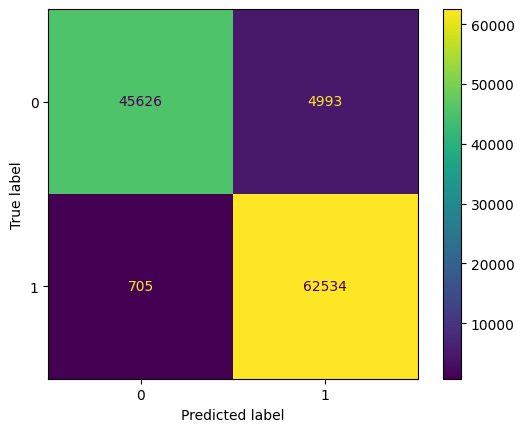

In [41]:

# Créez une matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()



# Prediction des types d'attaques

In [58]:
final_df_for_attack.columns

Index(['ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_state_ttl', 'ackdat',
       'synack', 'dintpkt', 'sintpkt', 'djit', 'res_bdy_len', 'trans_depth',
       'dmeansz', 'smeansz', 'dtcpb', 'stcpb', 'dpkts', 'spkts', 'dload',
       'sload', 'dur', 'is_sm_ips_ports', 'proto', 'state', 'service',
       'attack_cat'],
      dtype='object')

In [59]:
# Séparation des données en ensembles d'entraînement et de test
X = final_df_for_attack.drop(columns='attack_cat')
y = final_df_for_attack['attack_cat']

# Création de variables dummy pour les variables catégorielles
X_dummies = pd.get_dummies(X, drop_first=True)

# Séparation des données en ensembles d'entraînement et de test après avoir créé des variables dummy
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

# Entraînement du modèle SVM avec un noyau radial ('rbf' est le choix par défaut)
svm_model_attack = SVC(kernel='rbf')
svm_model_attack.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = svm_model_attack.predict(X_test)

# Évaluation du modèle
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



## 4- Générer les mesures de centralités & classification

```
pour le noeud de destination et source (9*2)

       'degree': graph.degree(),
        'closeness_centrality': graph.closeness(),
        'betweenness_centrality': graph.betweenness(),
        'eigenvector_centrality': graph.eigenvector_centrality(),
        'clustering_coefficient': graph.transitivity_local_undirected(mode='zero'),
        'pagerank': graph.pagerank(),
        'coreness': graph.coreness(),  # K-core centrality
        # Pour les mesures spectrales comme 'hits', vous pouvez avoir besoin de décomposer les résultats en autorité et hub
        'authority_score': graph.authority_score(),
        'hub_score': graph.hub_score()

```

In [37]:
print(final_df.head())

    ct_dst_sport_ltm  ct_dst_src_ltm  ct_state_ttl    ackdat    synack  \
21               0.0             0.0      0.166667  0.008154  0.001443   
22               0.0             0.0      0.166667  0.008731  0.003969   
39               0.0             0.0      0.166667  0.008369  0.001932   
40               0.0             0.0      0.166667  0.008040  0.001404   
57               0.0             0.0      0.166667  0.008146  0.001564   

     dintpkt   sintpkt      djit  res_bdy_len  trans_depth  ...     dpkts  \
21  0.000166  0.000259  0.002471     0.001834     0.005814  ...  0.002178   
22  0.008214  0.002176  0.002033     0.000000     0.005814  ...  0.000545   
39  0.000577  0.000140  0.000103     0.000000     0.000000  ...  0.000545   
40  0.000638  0.000220  0.000129     0.000000     0.005814  ...  0.000545   
57  0.000590  0.000228  0.000134     0.000000     0.005814  ...  0.000545   

       spkts     dload         sload       dur  is_sm_ips_ports  Label  proto  \
21  0.00112

In [41]:
def add_network_measures_to_df(graph, df):
    # Calculer les mesures pour chaque nœud
    node_measures = {
        'degree': graph.degree(),
        'closeness_centrality': graph.closeness(),
        'betweenness_centrality': graph.betweenness(),
        'eigenvector_centrality': graph.eigenvector_centrality(),
        'clustering_coefficient': graph.transitivity_local_undirected(mode='zero'),
        'pagerank': graph.pagerank(),
        'coreness': graph.coreness(),  # K-core centrality
        # Pour les mesures spectrales comme 'hits', vous pouvez avoir besoin de décomposer les résultats en autorité et hub
        'authority_score': graph.authority_score(),
        'hub_score': graph.hub_score()
    }

    # Créer un dictionnaire pour mapper les noms des nœuds à leurs mesures
    node_to_measures = {node['name']: {measure: values[idx] for measure, values in node_measures.items()} for idx, node in enumerate(graph.vs)}

    # Initialiser les colonnes de mesures dans le DataFrame avec des valeurs par défaut (par exemple, NaN)
    for measure in node_measures.keys():
        df[measure + '_src'] = float('nan')
        df[measure + '_dst'] = float('nan')

    # Attribuer les valeurs aux lignes en fonction des nœuds source et destination
    for index, row in df.iterrows():
        src_node = row['source_node']
        dst_node = row['destination_node']

        if src_node in node_to_measures:
            for measure in node_measures.keys():
                df.at[index, measure + '_src'] = node_to_measures[src_node][measure]

        if dst_node in node_to_measures:
            for measure in node_measures.keys():
                df.at[index, measure + '_dst'] = node_to_measures[dst_node][measure]

    return df


In [42]:
df_largest_component.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label,source_node,destination_node
21,175.45.176.2,23357,149.171.126.16,80,tcp,FIN,0.240139,918,25552,62,...,2,2,1,1,1,1,Exploits,1,175.45.176.2:23357,149.171.126.16:80
22,175.45.176.0,13284,149.171.126.16,80,tcp,FIN,2.390390,1362,268,254,...,2,2,1,1,1,1,Reconnaissance,1,175.45.176.0:13284,149.171.126.16:80
39,175.45.176.2,13792,149.171.126.16,5555,tcp,FIN,0.175190,8168,268,254,...,1,1,1,1,1,1,Exploits,1,175.45.176.2:13792,149.171.126.16:5555
40,175.45.176.2,26939,149.171.126.10,80,tcp,FIN,0.190600,844,268,254,...,1,1,1,1,1,1,Exploits,1,175.45.176.2:26939,149.171.126.10:80
57,175.45.176.0,39500,149.171.126.15,80,tcp,FIN,0.177449,1214,268,254,...,2,1,1,1,1,1,DoS,1,175.45.176.0:39500,149.171.126.15:80


In [43]:
to_update_df = df_largest_component.copy()
# add network measures to the DataFrame
update_df = add_network_measures_to_df(second_largest_component, to_update_df)
update_df.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,clustering_coefficient_src,clustering_coefficient_dst,pagerank_src,pagerank_dst,coreness_src,coreness_dst,authority_score_src,authority_score_dst,hub_score_src,hub_score_dst
21,175.45.176.2,23357,149.171.126.16,80,tcp,FIN,0.240139,918,25552,62,...,0.0,0.0,0.000006,0.009766,1.0,5.0,0.0,0.145633,0.081208,0.0
22,175.45.176.0,13284,149.171.126.16,80,tcp,FIN,2.390390,1362,268,254,...,0.0,0.0,0.000006,0.009766,1.0,5.0,0.0,0.145633,0.081208,0.0
39,175.45.176.2,13792,149.171.126.16,5555,tcp,FIN,0.175190,8168,268,254,...,0.0,0.0,0.000006,0.000076,1.0,2.0,0.0,0.000052,0.000029,0.0
40,175.45.176.2,26939,149.171.126.10,80,tcp,FIN,0.190600,844,268,254,...,0.0,0.0,0.000006,0.011537,1.0,5.0,0.0,0.319209,0.177998,0.0
57,175.45.176.0,39500,149.171.126.15,80,tcp,FIN,0.177449,1214,268,254,...,0.0,0.0,0.000006,0.009553,1.0,5.0,0.0,0.106903,0.059612,0.0


In [44]:
print(update_df.columns)

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'Label', 'source_node', 'destination_node', 'degree_src', 'degree_dst',
       'closeness_centrality_src', 'closeness_centrality_dst',
       'betweenness_centrality_src', 'betweenness_centrality_dst',
       'eigenvector_centrality_src', 'eigenvector_centrality_dst',
       'clustering_coefficient_src', 'clustering_coefficient_dst',
       'pagerank_src', 'pagerank_dst', 'coreness_src'

In [45]:
update_df['hub_score_src'].unique()

array([8.12083586e-02, 2.88415746e-05, 1.77998357e-01, ...,
       6.62338069e-06, 1.19974688e-02, 1.04737081e-05])

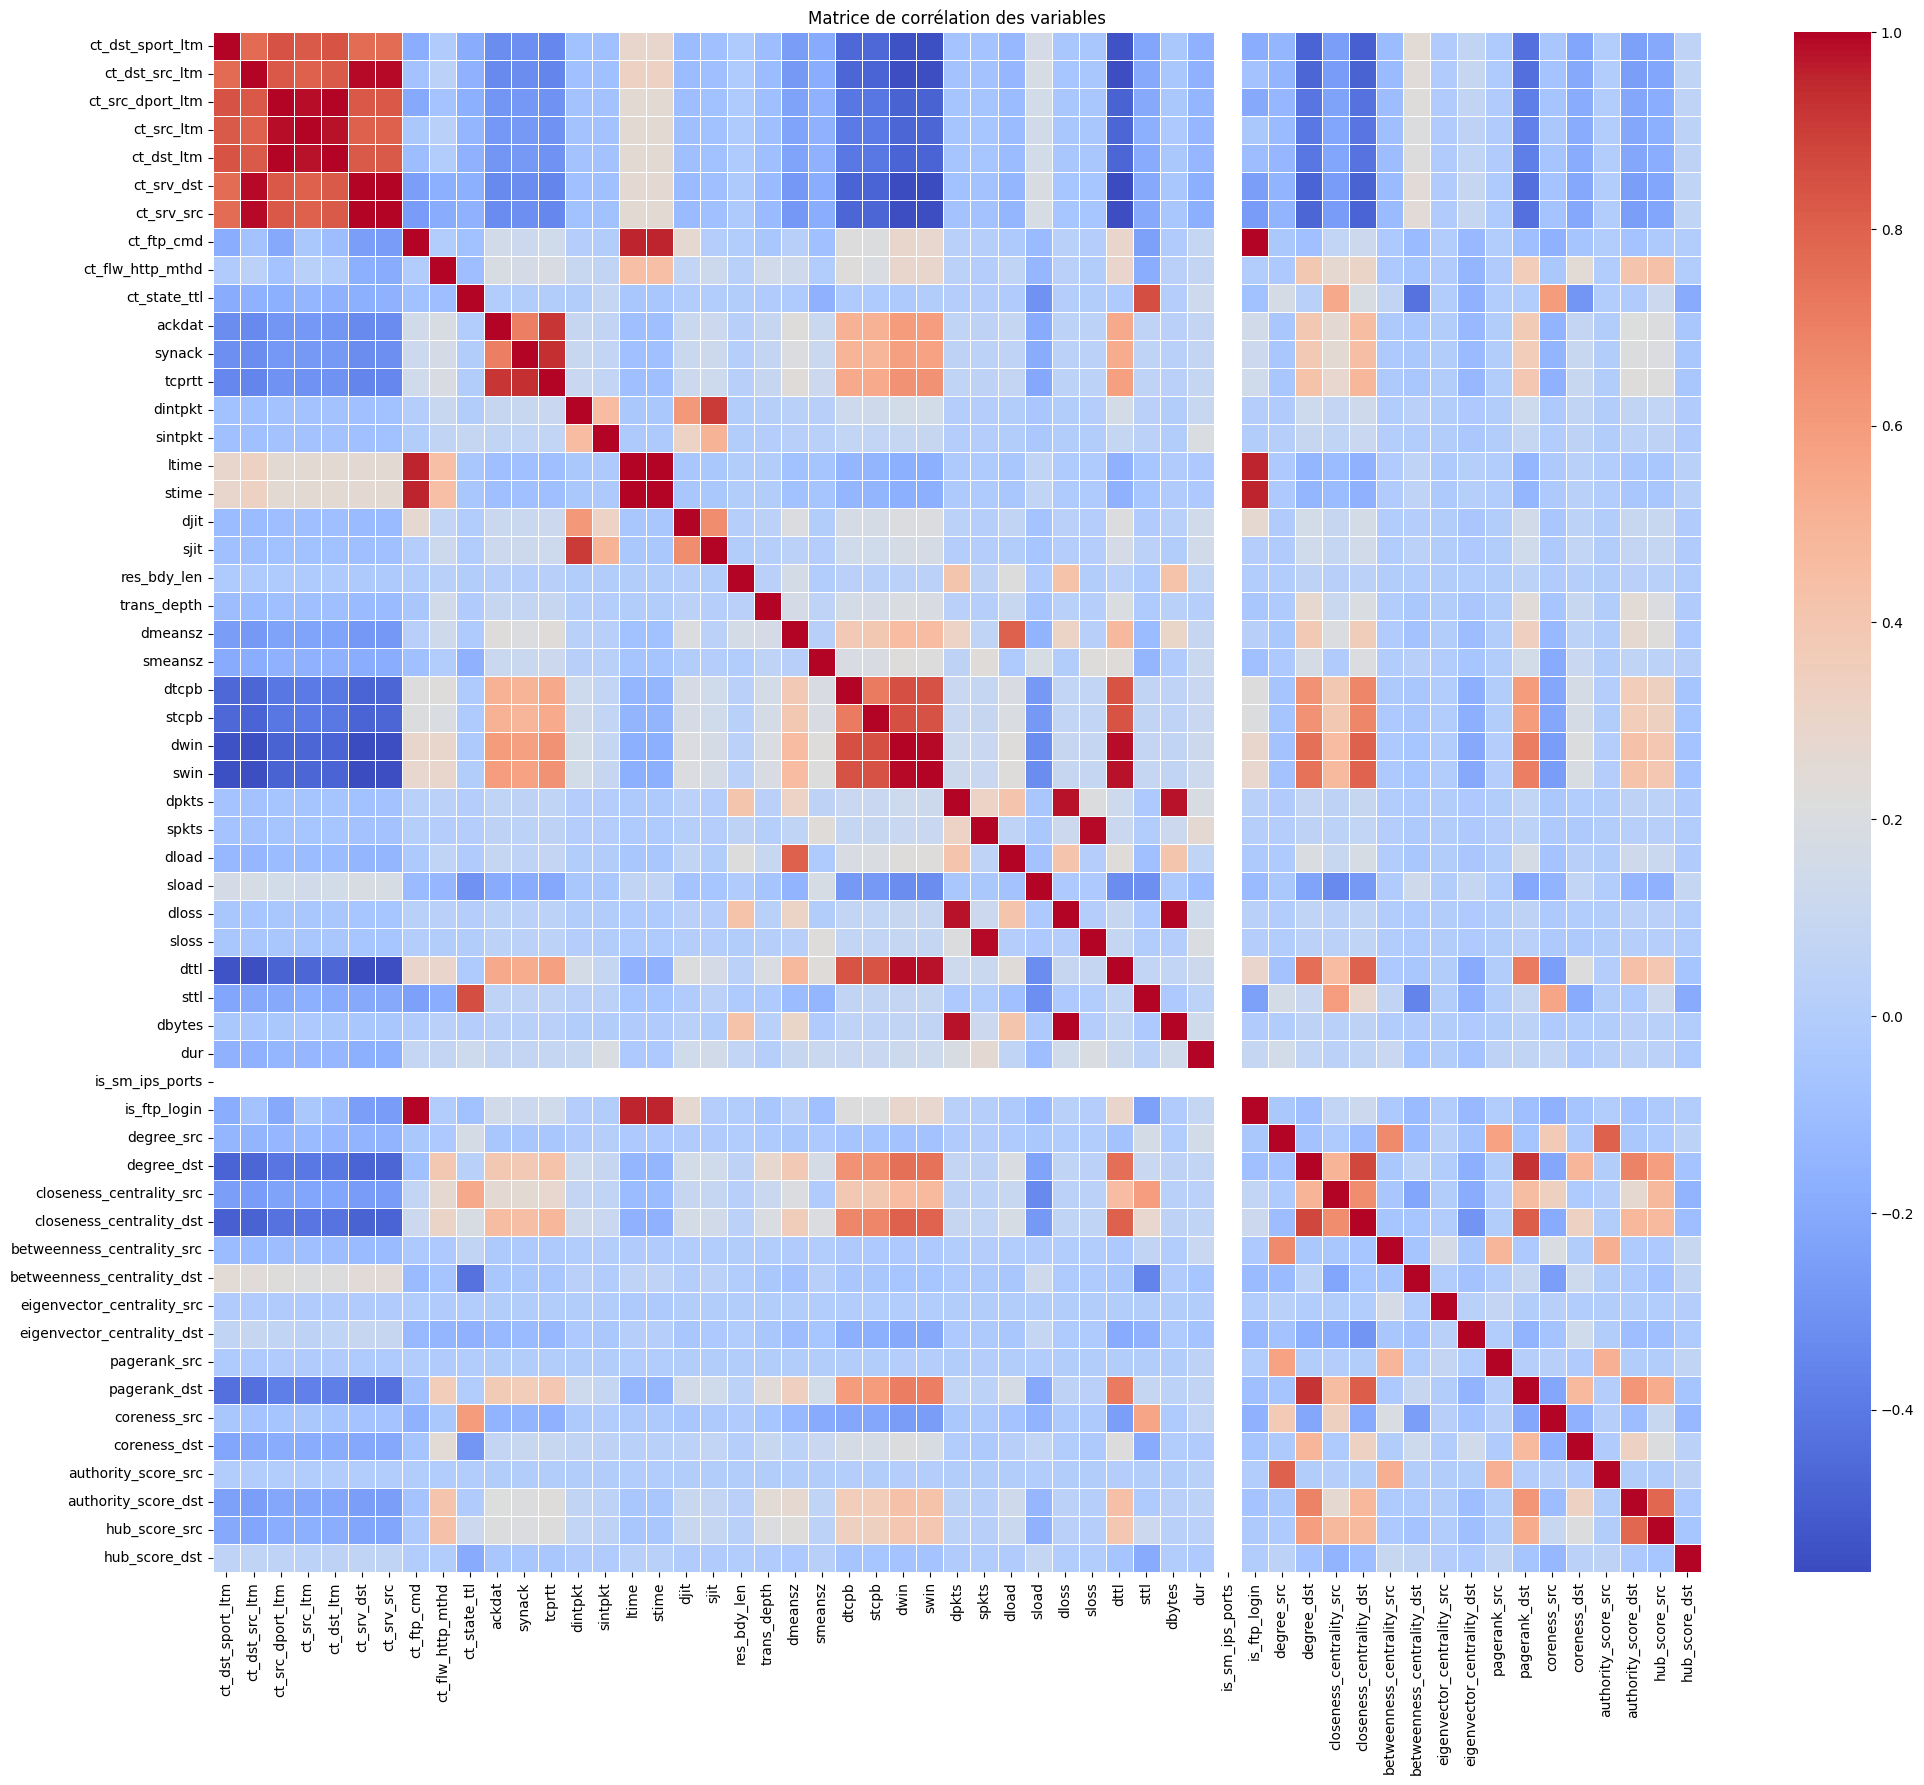

In [46]:
variables_int = ['ct_dst_sport_ltm', 'ct_dst_src_ltm','ct_src_dport_ltm','ct_src_ltm','ct_dst_ltm','ct_srv_dst','ct_srv_src','ct_ftp_cmd','ct_flw_http_mthd','ct_state_ttl','ackdat','synack','tcprtt','dintpkt',
             'sintpkt','ltime','stime','djit','sjit','res_bdy_len','trans_depth','dmeansz','smeansz','dtcpb','stcpb','dwin','swin','dpkts','spkts','dload','sload','dloss','sloss','dttl','sttl','dbytes','dur','is_sm_ips_ports','is_ftp_login','degree_src', 'degree_dst',
       'closeness_centrality_src', 'closeness_centrality_dst',
       'betweenness_centrality_src', 'betweenness_centrality_dst',
       'eigenvector_centrality_src', 'eigenvector_centrality_dst',
       'pagerank_src', 'pagerank_dst','coreness_src', 'coreness_dst',
       'authority_score_src', 'authority_score_dst', 'hub_score_src',
       'hub_score_dst']

# Calcul de la matrice de corrélation
correlation_matrix_update = update_df[variables_int].corr()

# Création de la carte de chaleur
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix_update, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Matrice de corrélation des variables')
plt.show()

{'ct_src_ltm', 'ct_srv_src', 'stime', 'ct_srv_dst', 'sloss', 'sttl', 'ct_src_dport_ltm', 'dloss', 'sjit', 'ct_dst_ltm', 'tcprtt', 'authority_score_src', 'dwin', 'ltime', 'is_ftp_login', 'pagerank_dst', 'closeness_centrality_dst', 'swin', 'dttl', 'dbytes'}


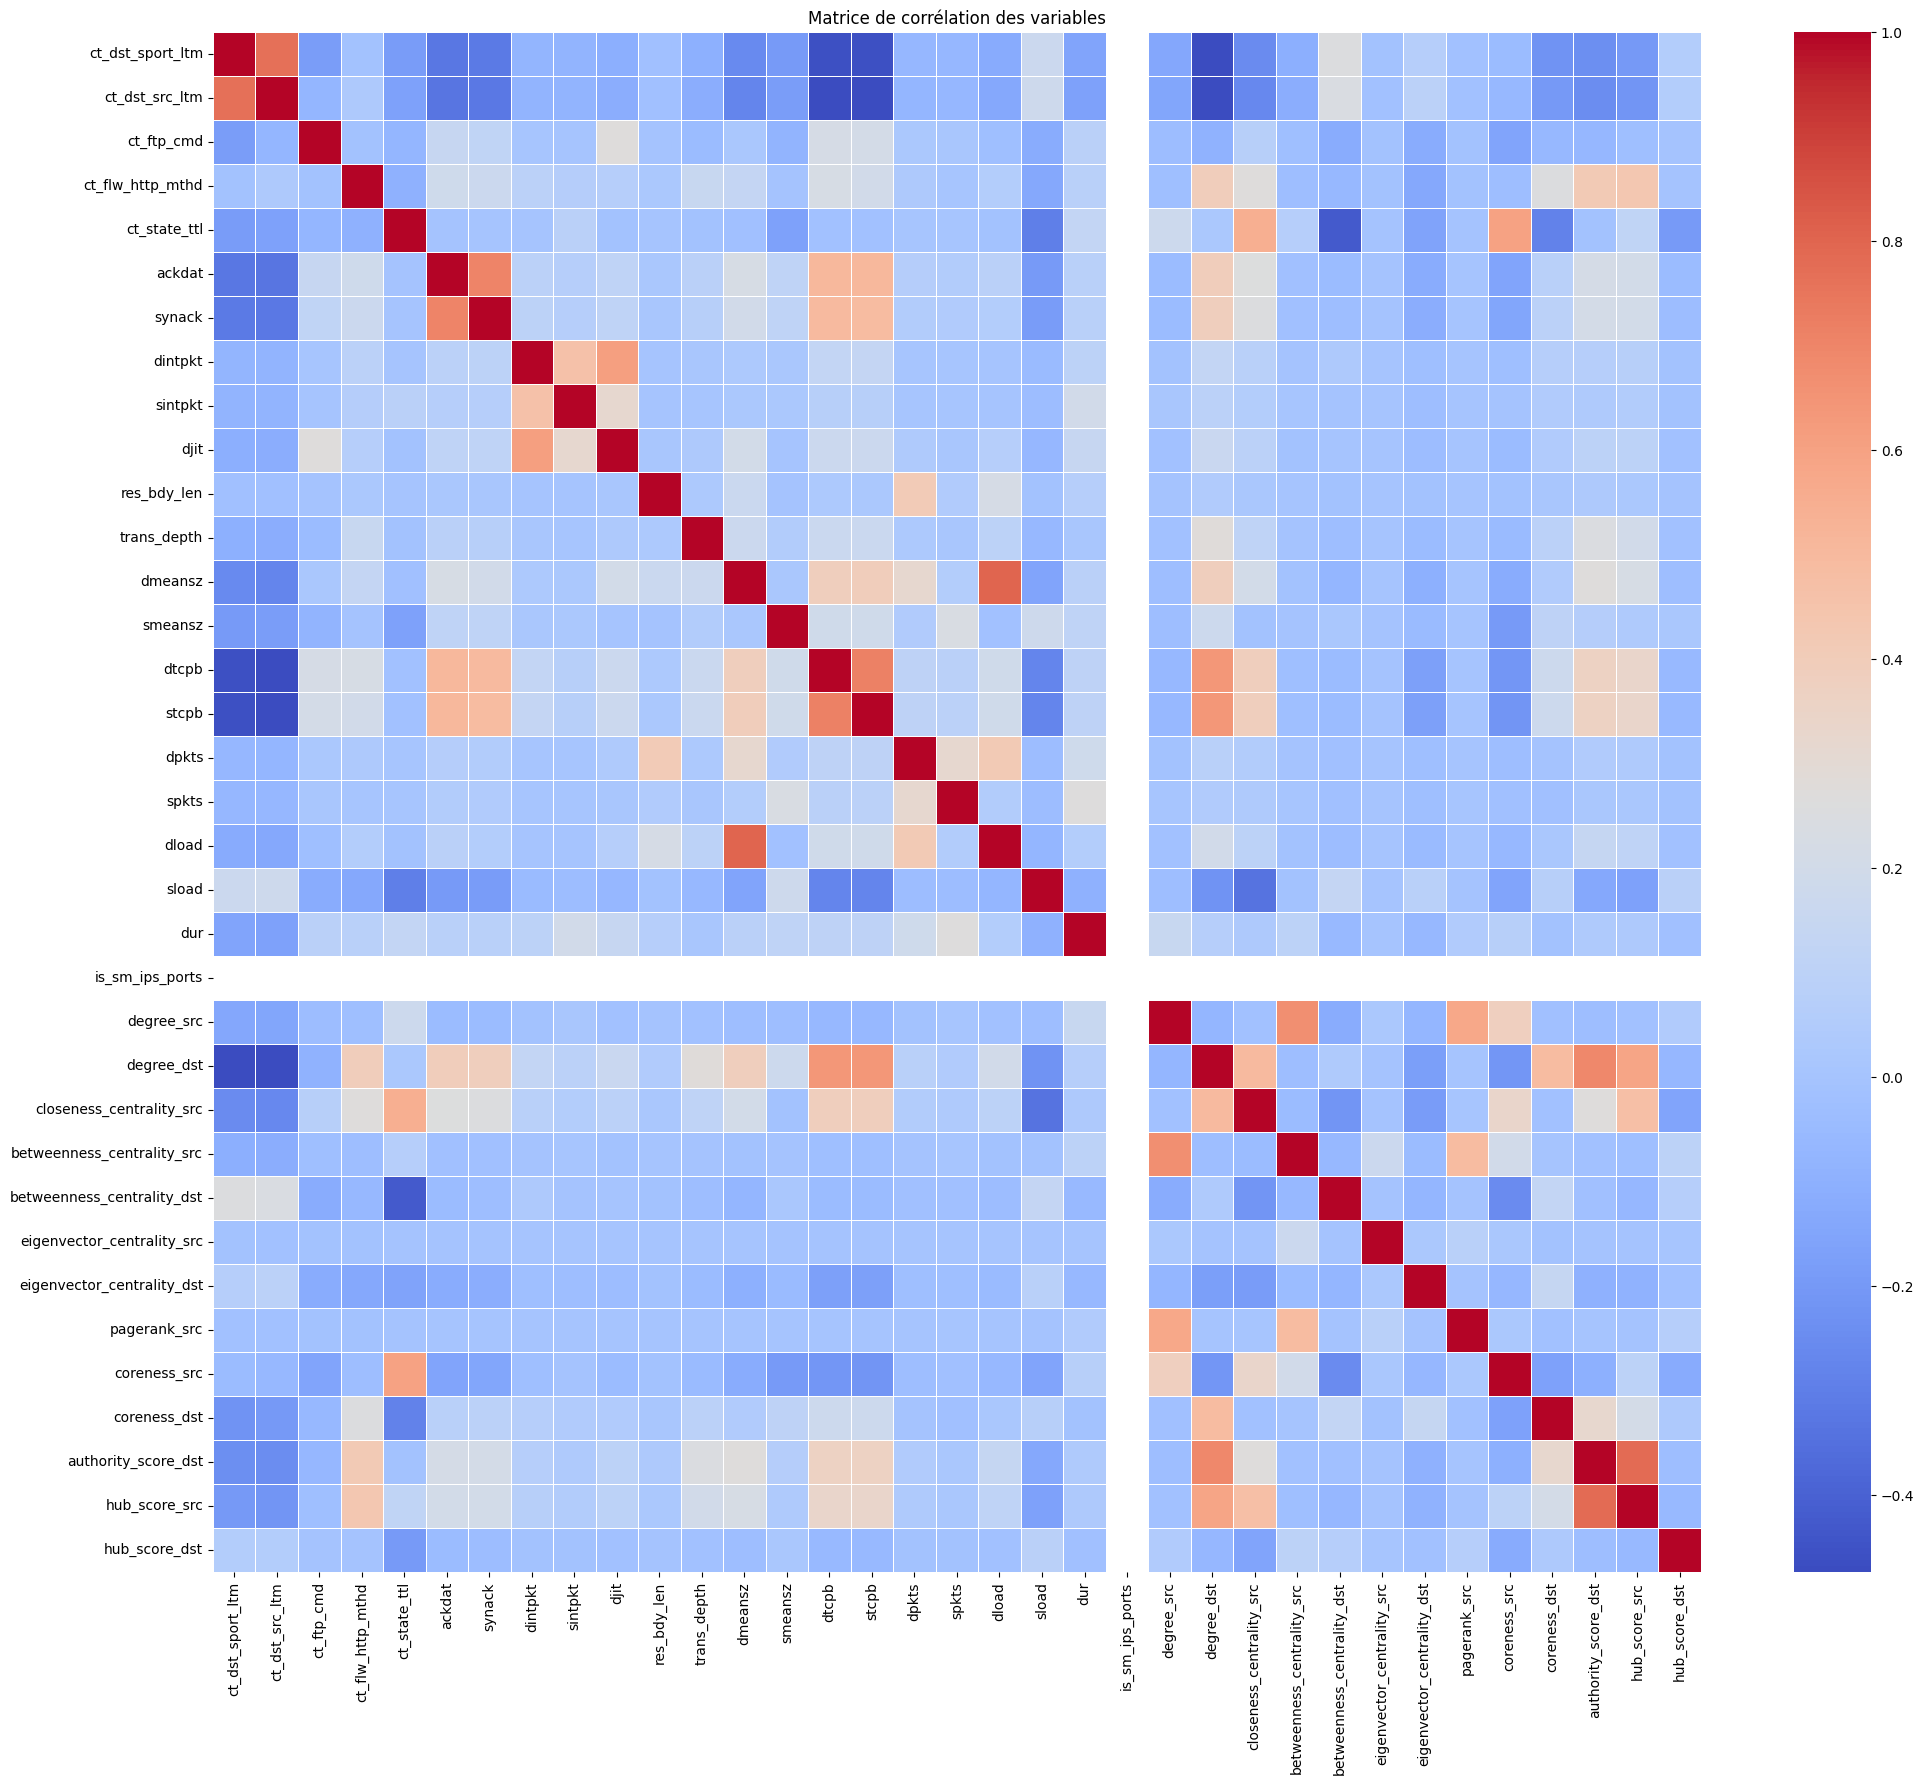

Index(['ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_state_ttl', 'ackdat', 'synack', 'dintpkt', 'sintpkt', 'djit',
       'res_bdy_len', 'trans_depth', 'dmeansz', 'smeansz', 'dtcpb', 'stcpb',
       'dpkts', 'spkts', 'dload', 'sload', 'dur', 'is_sm_ips_ports',
       'degree_src', 'degree_dst', 'closeness_centrality_src',
       'betweenness_centrality_src', 'betweenness_centrality_dst',
       'eigenvector_centrality_src', 'eigenvector_centrality_dst',
       'pagerank_src', 'coreness_src', 'coreness_dst', 'authority_score_dst',
       'hub_score_src', 'hub_score_dst'],
      dtype='object')

In [47]:

# Calcul de la matrice de corrélation
corr_matrix = update_df[variables_int].corr()

# Trouver les paires de variables fortement corrélées (au-dessus de 0.8)
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            # Si la corrélation est forte, ajouter l'un des deux à la liste des colonnes à supprimer
            to_drop.add(corr_matrix.columns[j])

# Afficher les paires de variables fortement corrélées
print(to_drop)

# Éliminer les variables fortement corrélées
update_df_reduced = update_df[variables_int].drop(columns=to_drop)

new_colonnes = update_df_reduced.columns

# Calcul de la matrice de corrélation
correlation_matrix = update_df_reduced.corr()

# Création de la carte de chaleur
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Matrice de corrélation des variables')
plt.show()

# Afficher les colonnes restantes
update_df_reduced.columns

In [48]:
int_keep_columns = update_df_reduced.columns
final_update_df = update_df_reduced
final_update_df['Label'] = update_df['Label']
# add nominal columns
final_update_df['proto'] = update_df['proto']
final_update_df['state'] = update_df['state']
final_update_df['service'] = update_df['service']
int_keep_columns

Index(['ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_state_ttl', 'ackdat', 'synack', 'dintpkt', 'sintpkt', 'djit',
       'res_bdy_len', 'trans_depth', 'dmeansz', 'smeansz', 'dtcpb', 'stcpb',
       'dpkts', 'spkts', 'dload', 'sload', 'dur', 'is_sm_ips_ports',
       'degree_src', 'degree_dst', 'closeness_centrality_src',
       'betweenness_centrality_src', 'betweenness_centrality_dst',
       'eigenvector_centrality_src', 'eigenvector_centrality_dst',
       'pagerank_src', 'coreness_src', 'coreness_dst', 'authority_score_dst',
       'hub_score_src', 'hub_score_dst'],
      dtype='object')

In [49]:
print(final_update_df.isnull().sum())

ct_dst_sport_ltm                   0
ct_dst_src_ltm                     0
ct_ftp_cmd                    534697
ct_flw_http_mthd              517135
ct_state_ttl                       0
ackdat                             0
synack                             0
dintpkt                            0
sintpkt                            0
djit                               0
res_bdy_len                        0
trans_depth                        0
dmeansz                            0
smeansz                            0
dtcpb                              0
stcpb                              0
dpkts                              0
spkts                              0
dload                              0
sload                              0
dur                                0
is_sm_ips_ports                    0
degree_src                         0
degree_dst                         0
closeness_centrality_src           0
betweenness_centrality_src         0
betweenness_centrality_dst         0
e

In [50]:
# Initialisation du MinMaxScaler.
scaler = MinMaxScaler()

# Normalisation des colonnes numériques spécifiées dans variables.
final_update_df[int_keep_columns] = scaler.fit_transform(final_update_df[int_keep_columns])

# drop columns with lots of null values 
final_update_df = final_update_df.drop(['ct_ftp_cmd'], axis=1)
final_update_df = final_update_df.drop(['ct_flw_http_mthd'], axis=1)

In [51]:
final_df_for_attack_update  = final_update_df
# drop label column
final_df_for_attack_update = final_df_for_attack_update.drop(columns=['Label'])
#add attack column
final_df_for_attack_update['attack_cat'] = df_largest_component['attack_cat']
final_df_for_attack_update['attack_cat'] = final_df_for_attack_update['attack_cat'].fillna('Normal')
# Maintenant, vous pouvez modifier component_df sans soulever l'avertissement
final_df_for_attack_update['attack_cat'] = final_df_for_attack_update['attack_cat'].str.strip()
print(final_df_for_attack_update['attack_cat'].unique())
final_df_for_attack_update.head()

['Exploits' 'Reconnaissance' 'DoS' 'Generic' 'Shellcode' 'Normal'
 'Fuzzers' 'Worms' 'Backdoors' 'Analysis' 'Backdoor']


,ct_dst_sport_ltm,ct_dst_src_ltm,ct_state_ttl,ackdat,synack,dintpkt,sintpkt,djit,res_bdy_len,trans_depth,...,pagerank_src,coreness_src,coreness_dst,authority_score_dst,hub_score_src,hub_score_dst,proto,state,service,attack_cat
21,0.0,0.0,0.166667,0.008154,0.001443,0.000166,0.000259,0.002471,0.001834,0.005814,...,0.0,0.0,1.00,0.145633,0.081208,0.0,tcp,FIN,http,Exploits
22,0.0,0.0,0.166667,0.008731,0.003969,0.008214,0.002176,0.002033,0.000000,0.005814,...,0.0,0.0,1.00,0.145633,0.081208,0.0,tcp,FIN,http,Reconnaissance
39,0.0,0.0,0.166667,0.008369,0.001932,0.000577,0.000140,0.000103,0.000000,0.000000,...,0.0,0.0,0.25,0.000052,0.000029,0.0,tcp,FIN,-,Exploits
40,0.0,0.0,0.166667,0.008040,0.001404,0.000638,0.000220,0.000129,0.000000,0.005814,...,0.0,0.0,1.00,0.319209,0.177998,0.0,tcp,FIN,http,Exploits
57,0.0,0.0,0.166667,0.008146,0.001564,0.000590,0.000228,0.000134,0.000000,0.005814,...,0.0,0.0,1.00,0.106903,0.059612,0.0,tcp,FIN,http,DoS


In [52]:

# Séparation des données en ensembles d'entraînement et de test
X = final_update_df.drop(columns='Label')
y = final_update_df['Label']

# Création de variables dummy pour les variables catégorielles
X_dummies = pd.get_dummies(X, drop_first=True)

# Séparation des données en ensembles d'entraînement et de test après avoir créé des variables dummy
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

# Entraînement du modèle SVM avec un noyau radial ('rbf' est le choix par défaut)
svm_model1 = SVC(kernel='rbf')
svm_model1.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = svm_model1.predict(X_test)

# Évaluation du modèle
print("Confusion Matrix update df:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report update df:")
print(classification_report(y_test, y_pred))



Confusion Matrix update df:
[[48315  2304]
 [ 1919 61320]]

Classification Report update df:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     50619
           1       0.96      0.97      0.97     63239

    accuracy                           0.96    113858
   macro avg       0.96      0.96      0.96    113858
weighted avg       0.96      0.96      0.96    113858



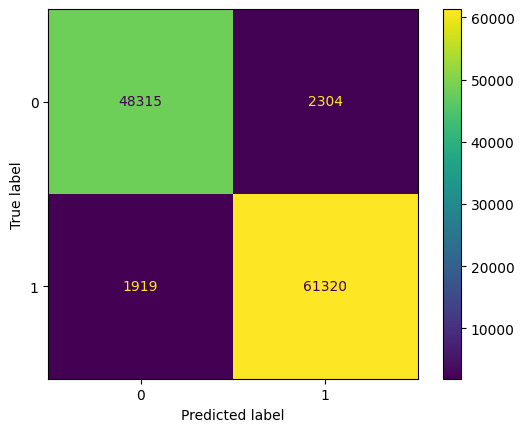

In [54]:

# Créez une matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model1.classes_)
disp.plot()



In [57]:
final_df_for_attack_update.columns

Index(['ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_state_ttl', 'ackdat',
       'synack', 'dintpkt', 'sintpkt', 'djit', 'res_bdy_len', 'trans_depth',
       'dmeansz', 'smeansz', 'dtcpb', 'stcpb', 'dpkts', 'spkts', 'dload',
       'sload', 'dur', 'is_sm_ips_ports', 'degree_src', 'degree_dst',
       'closeness_centrality_src', 'betweenness_centrality_src',
       'betweenness_centrality_dst', 'eigenvector_centrality_src',
       'eigenvector_centrality_dst', 'pagerank_src', 'coreness_src',
       'coreness_dst', 'authority_score_dst', 'hub_score_src', 'hub_score_dst',
       'proto', 'state', 'service', 'attack_cat'],
      dtype='object')

# Prediction des types d'attaques

In [ ]:
#prediction ds types d'attaques

In [ ]:
# Séparation des données en ensembles d'entraînement et de test
X = final_df_for_attack_update.drop(columns='attack_cat')
y = final_df_for_attack_update['attack_cat']

# Création de variables dummy pour les variables catégorielles
X_dummies = pd.get_dummies(X, drop_first=True)

# Séparation des données en ensembles d'entraînement et de test après avoir créé des variables dummy
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

# Entraînement du modèle SVM avec un noyau radial ('rbf' est le choix par défaut)
svm_model_update = SVC(kernel='rbf')
svm_model_update.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = svm_model_update.predict(X_test)

# Évaluation du modèle
print("Confusion Matrix update df:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report update df:")
print(classification_report(y_test, y_pred))

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Assurer que la colonne 'Label' existe dans votre DataFrame
if 'Label' in final_update_df.columns:
    # Séparation des données en ensembles d'entraînement et de test
    X = final_update_df.drop(columns='Label')
    y = final_update_df['Label']

    # Création de variables dummy pour les variables catégorielles
    X_dummies = pd.get_dummies(X, drop_first=True)


    # Séparation des données
    X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

    # Entraînement du modèle Random Forest
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Prédictions et évaluation
    y_pred = rf_model.predict(X_test)
    #print("Confusion Matrix update df:")
    #print(confusion_matrix(y_test, y_pred))
    #print("\nClassification Report update df:")
    #print(classification_report(y_test, y_pred))

    # Afficher l'importance des variables
    feature_importances = rf_model.feature_importances_
    importance_df = pd.DataFrame({'Feature': X_dummies.columns, 'Importance': feature_importances})
    print("\nFeature Importances:")
    print(importance_df.sort_values(by='Importance', ascending=False))
else:
    print("La colonne 'Label' est manquante dans le DataFrame.")



Feature Importances:
                      Feature  Importance
31              hub_score_src    0.139620
2                ct_state_ttl    0.114734
11                    smeansz    0.114327
22   closeness_centrality_src    0.098245
32              hub_score_dst    0.087548
..                        ...         ...
145                proto_tlsp    0.000000
58                  proto_esp    0.000000
125             proto_sat-mon    0.000000
65                  proto_hmp    0.000000
94            proto_kryptolan    0.000000

[190 rows x 2 columns]



Feature Importances:
                      Feature  Importance
31              hub_score_src    0.139620
2                ct_state_ttl    0.114734
11                    smeansz    0.114327
22   closeness_centrality_src    0.098245
32              hub_score_dst    0.087548
..                        ...         ...
145                proto_tlsp    0.000000
58                  proto_esp    0.000000
125             proto_sat-mon    0.000000
65                  proto_hmp    0.000000
94            proto_kryptolan    0.000000

[190 rows x 2 columns]


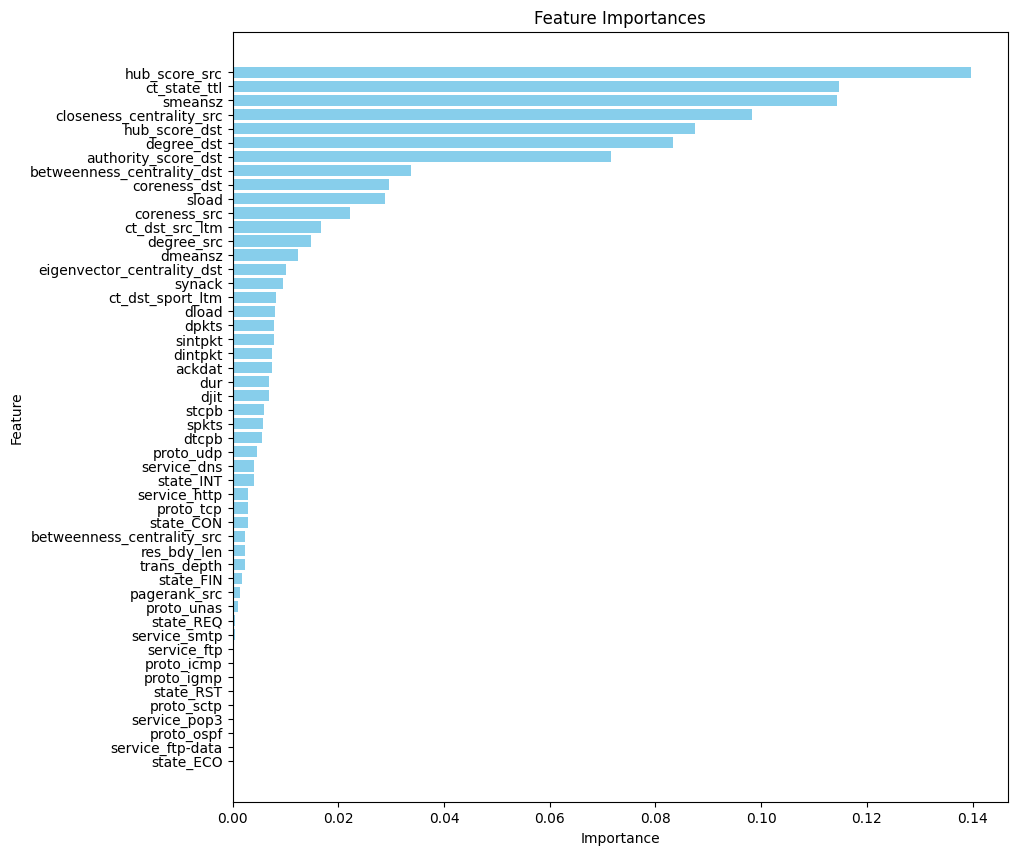

In [56]:
print("\nFeature Importances:")
print(importance_df.sort_values(by='Importance', ascending=False))

# Récupération de l'importance des caractéristiques
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_dummies.columns, 'Importance': feature_importances})

# Tri des importances pour la visualisation
importance_df_sorted_test = importance_df.sort_values(by='Importance', ascending=False).head(50)

# Création du graphique des 10 caractéristiques les plus importantes
plt.figure(figsize=(10, 10))
plt.barh(importance_df_sorted_test['Feature'], importance_df_sorted_test['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Inverser l'axe Y
plt.show()